In [2]:
import os,time, datetime, math, requests

In [3]:
# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import missingno
import seaborn as sns

# Feature Selection and Encoding
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# Machine learning
from sklearn import model_selection, preprocessing, metrics
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Grid and Random Search
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

# Managing Warnings
import warnings
warnings.filterwarnings('ignore')

# Plot the Figures Inline
%matplotlib inline

En este caso vamos a utilizar datos de un censo de población enfocado al salario de las personas encuestadas pueden ver el dataset [aquí](https://archive.ics.uci.edu/ml/datasets/adult)

In [4]:
# Download
DATASET = (
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
)

def download_data(path='dataset', urls=DATASET):
    if not os.path.exists(path):
        os.mkdir(path)

    for url in urls:
        response = requests.get(url)
        name = os.path.basename(url)
        with open(os.path.join(path, name), 'wb') as f:
            f.write(response.content)

download_data()

Una vez tengamos el dataset en nuestras computadoras podemos proceder a cargar los datos utilizando pandas

In [5]:
# Load Training and Test Data Sets
headers = ['age', 'workclass', 'fnlwgt',
           'education', 'education-num',
           'marital-status', 'occupation',
           'relationship', 'race', 'sex',
           'capital-gain', 'capital-loss',
           'hours-per-week', 'native-country',
           'predclass']
training_raw = pd.read_csv('dataset/adult.data',
                       header=None,
                       names=headers,
                       sep=',\s',
                       na_values=["?"],
                       engine='python')
test_raw = pd.read_csv('dataset/adult.test',
                      header=None,
                      names=headers,
                      sep=',\s',
                      na_values=["?"],
                      engine='python',
                      skiprows=1)

In [6]:
# Join Datasets
dataset_raw = pd.concat([training_raw, test_raw], ignore_index=True)
dataset_raw.reset_index(inplace=True)
dataset_raw.drop('index',inplace=True,axis=1)

In [7]:
# Displaying the size of the Dataframe in Memory
def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("Bytes", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])
convert_size(dataset_raw.memory_usage().sum())

'5.59 MB'

# Exploración de Datos - Univariable
La clase pasada vimos los _features_, los cuales puedes ser de multiples tipos:
- Nominal: Categorias sin orden y mutuamente exclusivas
- Ordinal: El orden importa pero la diferencia entre valores no importa
- Intervalo: Medida donde la diferencia entre dos valores es significativa
- Ratio: Mismas propiedades que un intervalo y una definición clara de 0.0

Para mayor facilidad vamos a continuar viendo los _features_ como dos tipos:
- Numéricos: Valores de numeros reales
- Categoricos: Texto ó categorías

In [8]:
# Describing all the Numerical Features
dataset_raw.describe()

age        fnlwgt  education-num  capital-gain  capital-loss  \
count  48842.000000  4.884200e+04   48842.000000  48842.000000  48842.000000   
mean      38.643585  1.896641e+05      10.078089   1079.067626     87.502314   
std       13.710510  1.056040e+05       2.570973   7452.019058    403.004552   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.175505e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.781445e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.376420e+05      12.000000      0.000000      0.000000   
max       90.000000  1.490400e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    48842.000000  
mean        40.422382  
std         12.391444  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000

In [9]:
# Describing all the Categorical Features
dataset_raw.describe(include=['O'])

workclass education      marital-status      occupation relationship  \
count      46043     48842               48842           46033        48842   
unique         8        16                   7              14            6   
top      Private   HS-grad  Married-civ-spouse  Prof-specialty      Husband   
freq       33906     15784               22379            6172        19716   

         race    sex native-country predclass  
count   48842  48842          47985     48842  
unique      5      2             41         4  
top     White   Male  United-States     <=50K  
freq    41762  32650          43832     24720

In [10]:
# Let's have a quick look at our data
dataset_raw.head()

age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country predclass  
0          2174             0              40  United-States     <=50K  
1             0             0              13  United-States     <=50K  
2             0             0              40  United-States     <=50K  
3             0             0              40  United-States     <=50K  
4             0             0              40           Cuba     <=50K

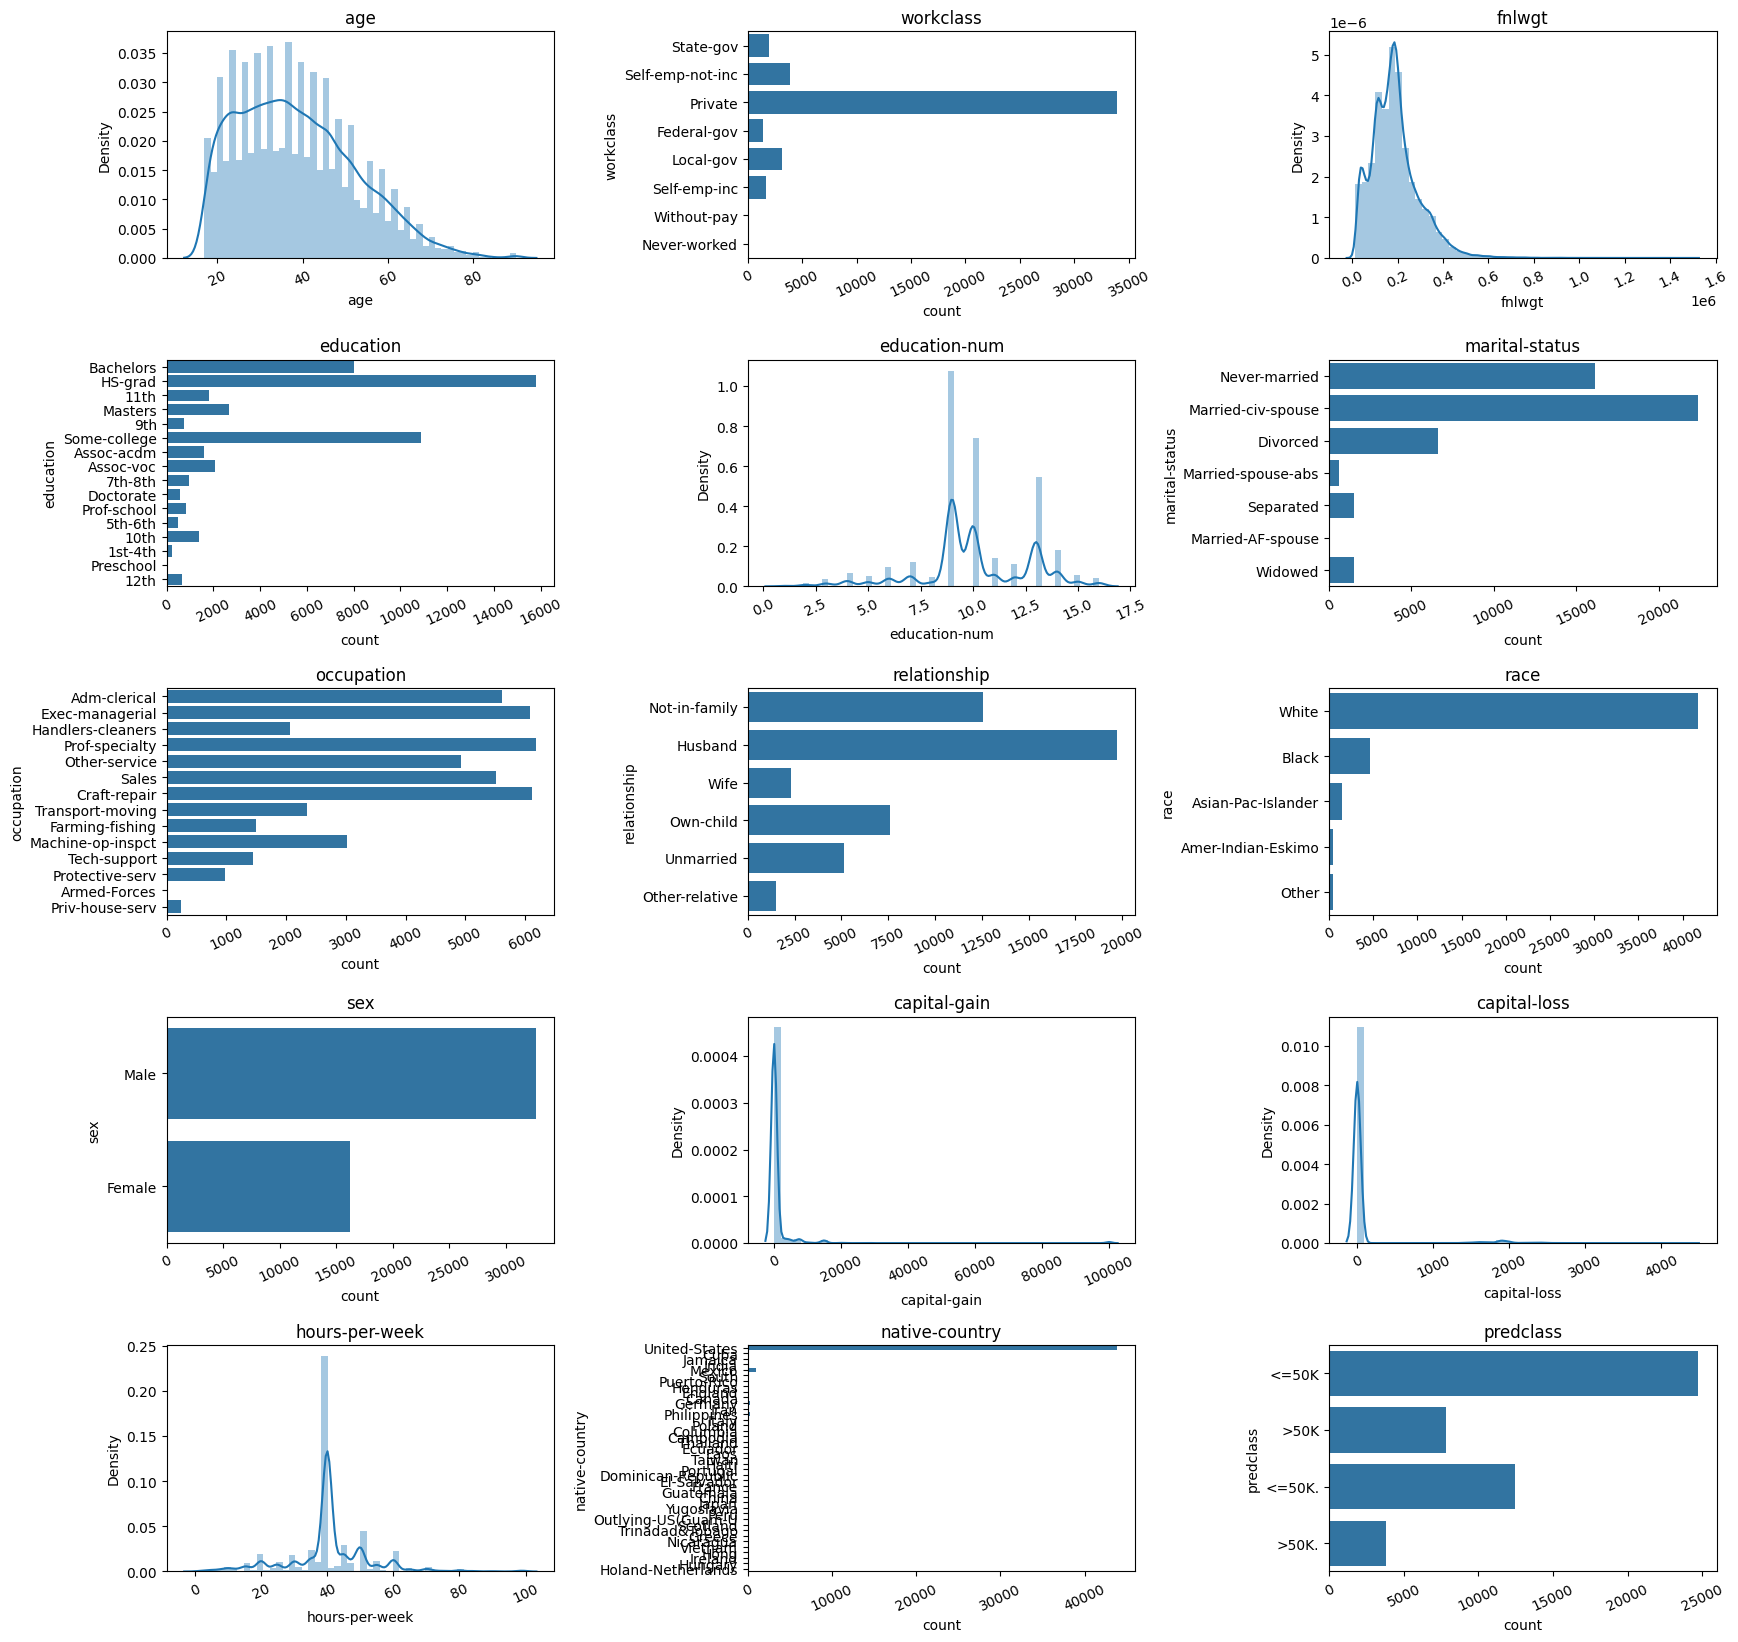

In [11]:
# Let’s plot the distribution of each feature
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)

plot_distribution(dataset_raw, cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

missingno es una librería de Python que nos ayuda a graficar valores faltantes en nuestros datos

<Axes: >

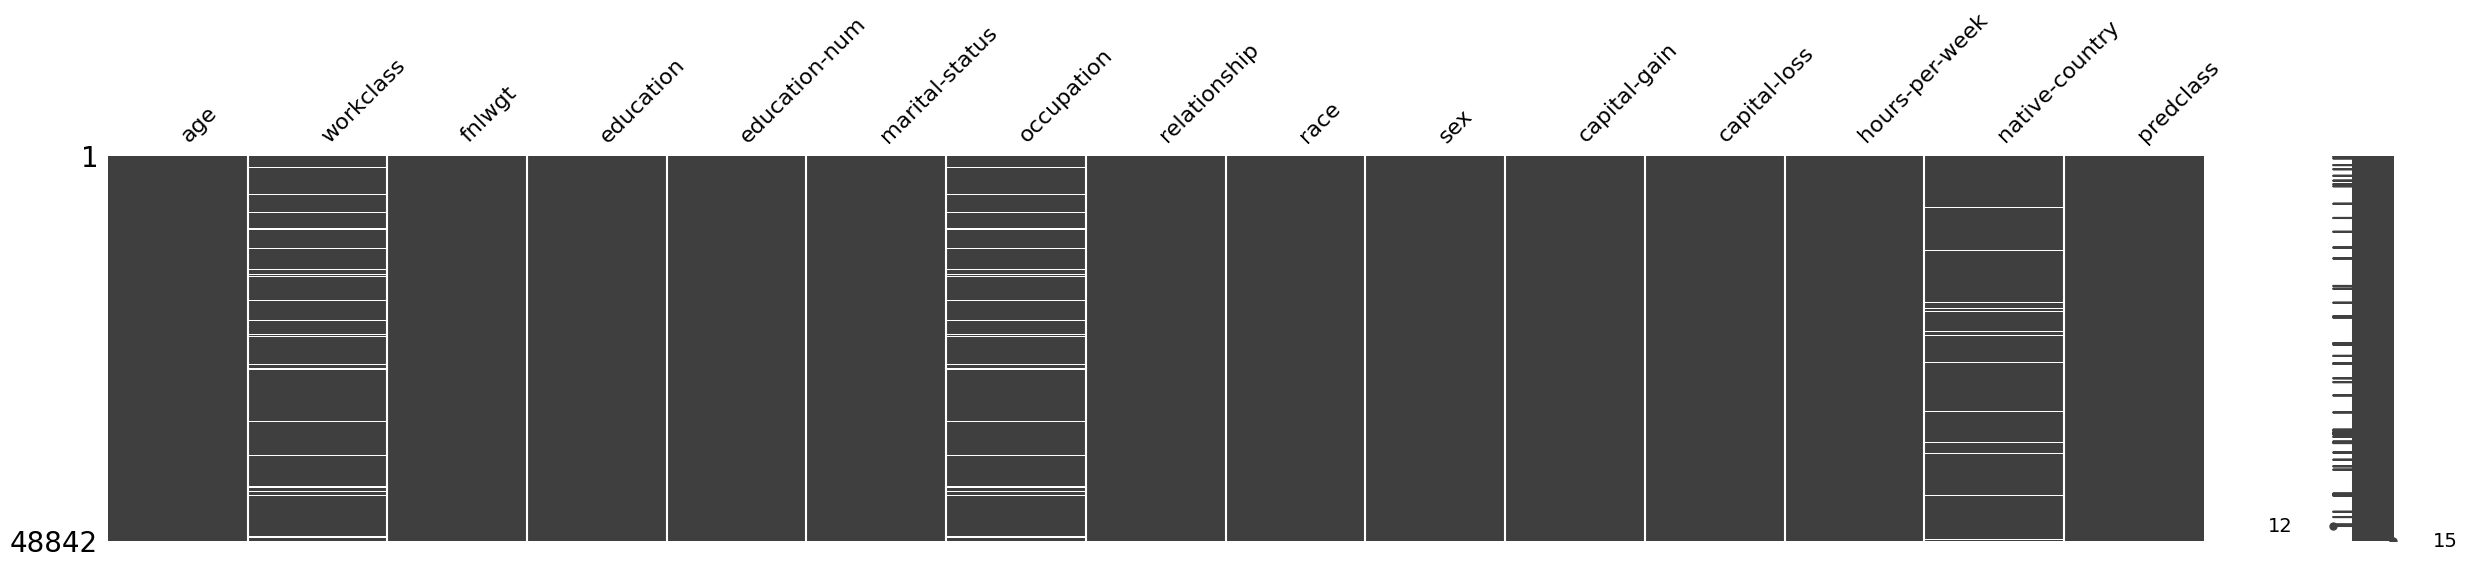

In [12]:
# How many missing values are there in our dataset?
missingno.matrix(dataset_raw, figsize = (30,5))

<Axes: >

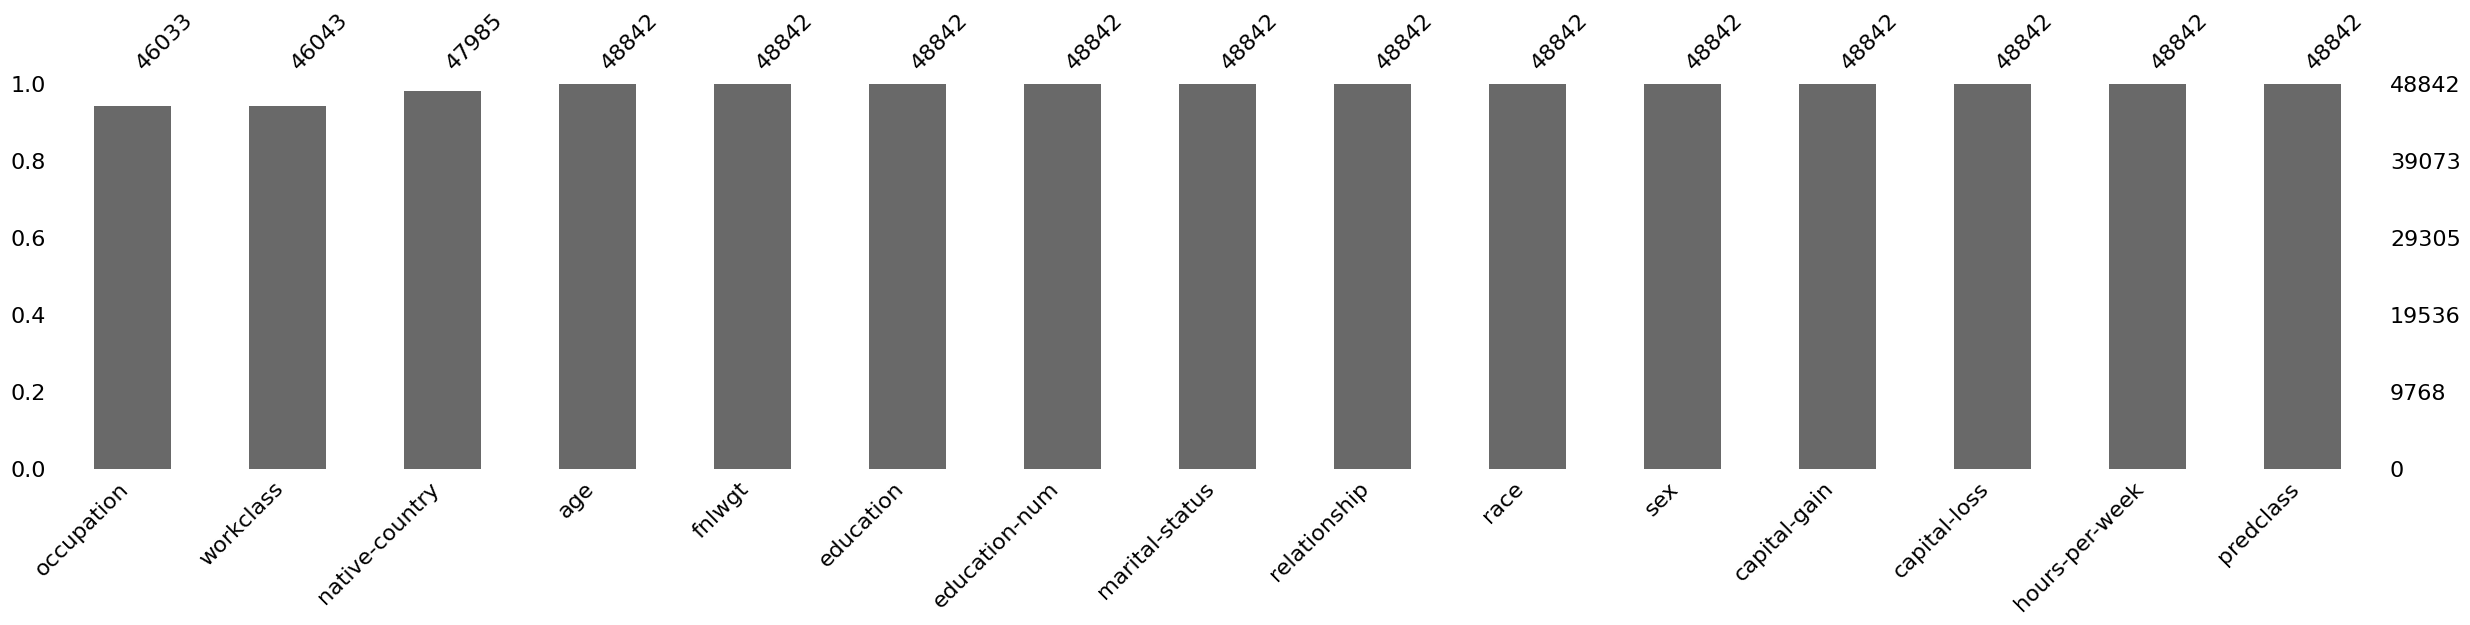

In [13]:
missingno.bar(dataset_raw, sort='ascending', figsize = (30,5))

# Limpieza de Datos
## Valores Faltantes
Como lo vimos la clase pasada hay dos opciones:
1. Omitir rows con valores faltantes
2. Imputar (rellenar) los valores faltante
## Valores Especiales
Algunas columnas numéricas pueden traer valores especiales como NaN +-Inf, etc. Los cálculos numéricos se pueden ver afectados por estos valores, con lo cual tenemos que manejarlos o eliminarlos
## Outliers
Outliers son valores que se salen de lo normal, (valores muy grandes o muy pequeños), no necesariamente hay que eliminarlos, es más una decisión estadística
## Inconsistencias Obvias
Algunos valores de la data pueden ser inconsistentes, por ejemplo que hayan rows representando personas masculinas embarazadas, edades negativas, menores de edad con licencia, etc. Estas inconsistencias hay que eliminarlas o manejarlas

# Feature Engineering
Es un proceso mediante el cual transformamos los _features_ de nuestros datos en nuevos _features_

## Decomposición
Convertir 2014-09-20T20:45:40Z en features categoricos como hora_dia, dia_mes, mes, año, entro otros

## Discretización
Puede ser beneficioso hacer este proceso sobre variables continuas, algunos algoritmos van a ser más rápido, vamos a hacer la comparación al final de cual opción fue la mejor para nuestros datos

In [15]:
# To perform our data analysis, let's create new dataframes.
dataset_bin = pd.DataFrame() # To contain our dataframe with our discretised continuous variables
dataset_con = pd.DataFrame() # To contain our dataframe with our continuous variables

Vamos a intentar predecir el salario de una persona parte del censo. Para esto creamos un target que será llamado _predclass_ y tendrá valores booleanos, 1 = salario mayor a \$ 50k 0 = salario menor a \$ 50k

In [16]:
# Let's fix the Class Feature
dataset_raw.loc[dataset_raw['predclass'] == '>50K', 'predclass'] = 1
dataset_raw.loc[dataset_raw['predclass'] == '>50K.', 'predclass'] = 1
dataset_raw.loc[dataset_raw['predclass'] == '<=50K', 'predclass'] = 0
dataset_raw.loc[dataset_raw['predclass'] == '<=50K.', 'predclass'] = 0

dataset_bin['predclass'] = dataset_raw['predclass']
dataset_con['predclass'] = dataset_raw['predclass']

En este gráfico podemos observar la cantidad de personas con salario clase 1 o clase 0. Claramente la clase 0 tiene más densidad de los datos

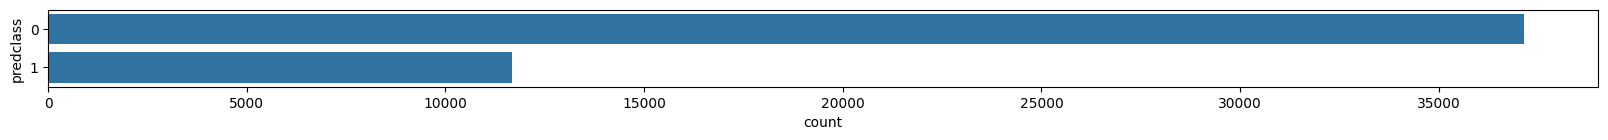

In [17]:
fig = plt.figure(figsize=(20,1))
sns.countplot(y="predclass", data=dataset_bin);

Vamos a utilizar el método cut de pandas para dividir nuestros datos en _buckets_ por edad, pandas automaticamente identifica buckets de tal manera que todos los datos queden adecuadamente distribuidos

In [18]:
dataset_raw['age']

0        39
1        50
2        38
3        53
4        28
         ..
48837    39
48838    64
48839    38
48840    44
48841    35
Name: age, Length: 48842, dtype: int64

In [19]:
dataset_bin['age'] = pd.cut(dataset_raw['age'], 10) # discretised
dataset_con['age'] = dataset_raw['age'] # non-discretised

In [20]:
dataset_bin

predclass           age
0             0  (38.9, 46.2]
1             0  (46.2, 53.5]
2             0  (31.6, 38.9]
3             0  (46.2, 53.5]
4             0  (24.3, 31.6]
...         ...           ...
48837         0  (38.9, 46.2]
48838         0  (60.8, 68.1]
48839         0  (31.6, 38.9]
48840         0  (38.9, 46.2]
48841         1  (31.6, 38.9]

[48842 rows x 2 columns]

In [21]:
dataset_con

predclass  age
0             0   39
1             0   50
2             0   38
3             0   53
4             0   28
...         ...  ...
48837         0   39
48838         0   64
48839         0   38
48840         0   44
48841         1   35

[48842 rows x 2 columns]

<Axes: xlabel='age', ylabel='Density'>

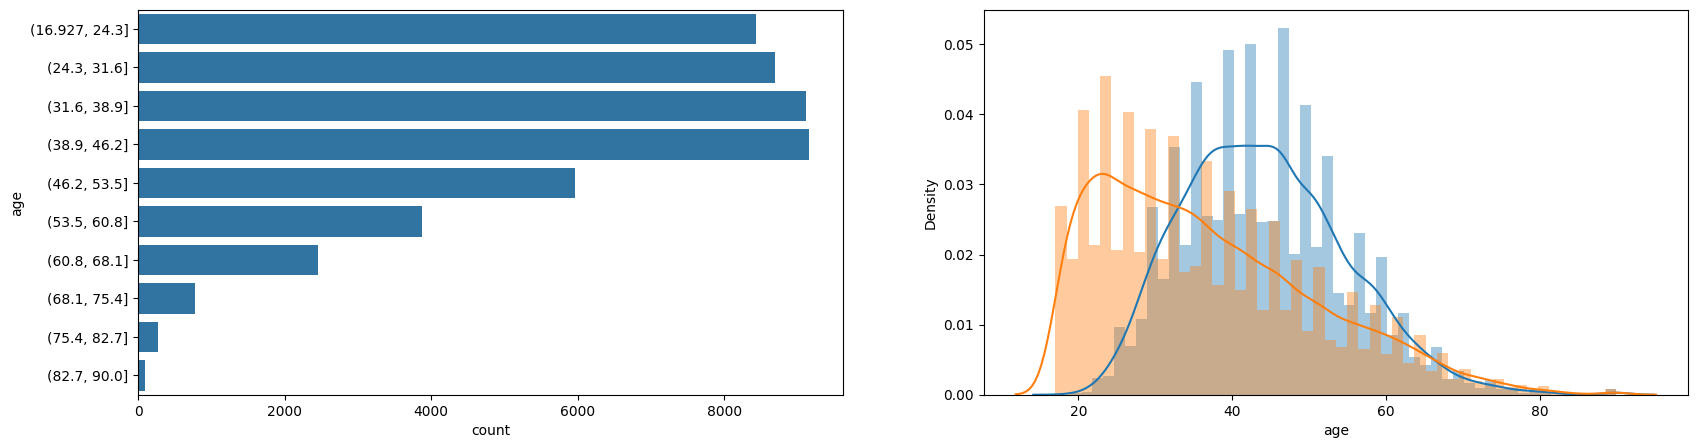

In [22]:
fig = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.countplot(y="age", data=dataset_bin)
plt.subplot(1, 2, 2)
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 1]['age'], kde_kws={"label": ">$50K"})
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 0]['age'], kde_kws={"label": "<$50K"})

Ahora vamos a ver el feature `workclass`
Vean el grádfico y como tenemos muchos grupos que talvez podamos crear nuevos subgrupos más consistentes. Vamos a crear nuevos buckets para simplificar esta columna

<Axes: xlabel='count', ylabel='workclass'>

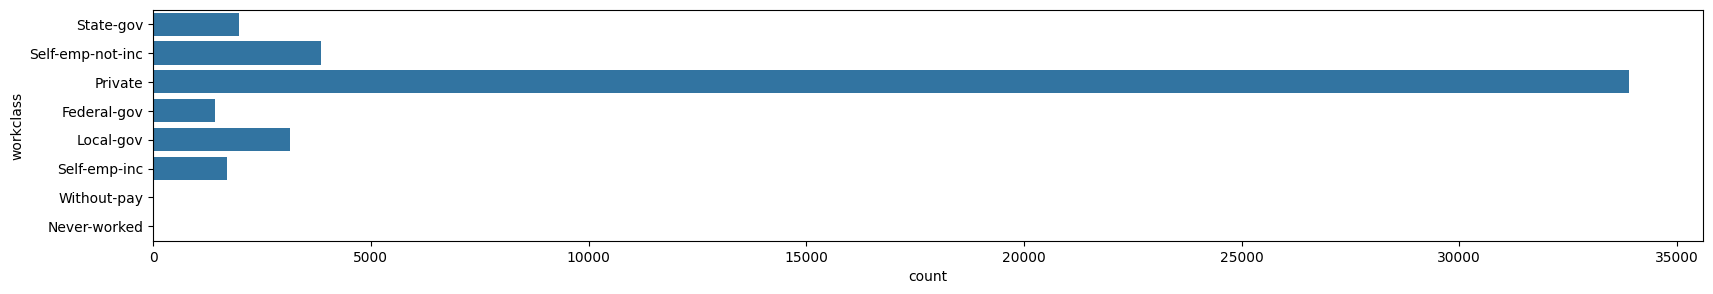

In [23]:
plt.figure(figsize=(20,3))
sns.countplot(y="workclass", data=dataset_raw)

In [25]:
# There are too many groups here, we can group some of them together.
# Create buckets for Workclass
dataset_raw.loc[dataset_raw['workclass'] == 'Without-pay', 'workclass'] = 'Not Working'
dataset_raw.loc[dataset_raw['workclass'] == 'Never-worked', 'workclass'] = 'Not Working'
dataset_raw.loc[dataset_raw['workclass'] == 'Federal-gov', 'workclass'] = 'Fed-gov'
dataset_raw.loc[dataset_raw['workclass'] == 'State-gov', 'workclass'] = 'Non-fed-gov'
dataset_raw.loc[dataset_raw['workclass'] == 'Local-gov', 'workclass'] = 'Non-fed-gov'
dataset_raw.loc[dataset_raw['workclass'] == 'Self-emp-not-inc', 'workclass'] = 'Self-emp'
dataset_raw.loc[dataset_raw['workclass'] == 'Self-emp-inc', 'workclass'] = 'Self-emp'

dataset_bin['workclass'] = dataset_raw['workclass']
dataset_con['workclass'] = dataset_raw['workclass']

<Axes: xlabel='count', ylabel='workclass'>

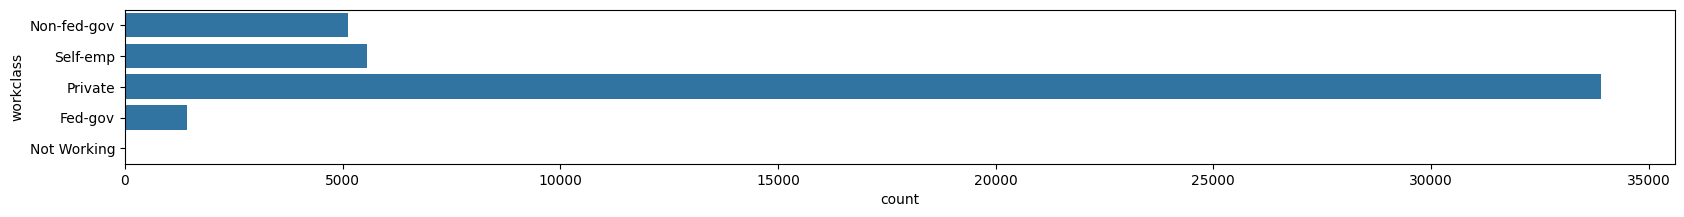

In [26]:
fig = plt.figure(figsize=(20,2))
sns.countplot(y="workclass", data=dataset_bin)

Haremos lo mismo con el feature de occupation, native-country, education, marital status

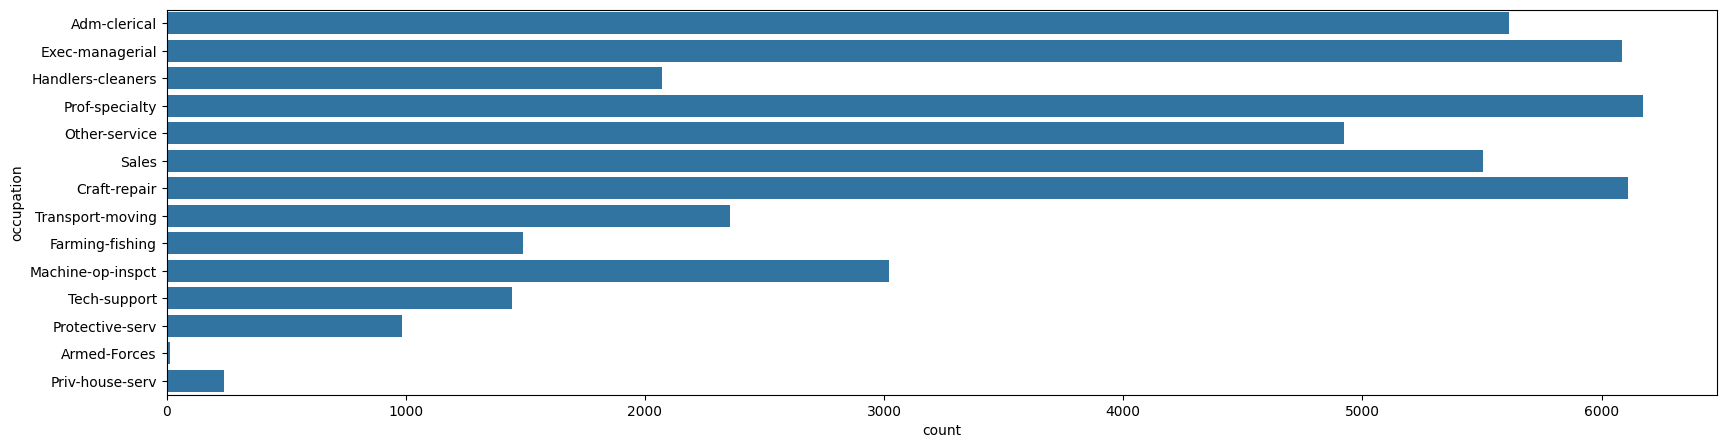

In [27]:
# Can we bucket some of these groups?
plt.figure(figsize=(20,5))
sns.countplot(y="occupation", data=dataset_raw);

In [28]:
# Create buckets for Occupation
dataset_raw.loc[dataset_raw['occupation'] == 'Adm-clerical', 'occupation'] = 'Admin'
dataset_raw.loc[dataset_raw['occupation'] == 'Armed-Forces', 'occupation'] = 'Military'
dataset_raw.loc[dataset_raw['occupation'] == 'Craft-repair', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Exec-managerial', 'occupation'] = 'Office Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Farming-fishing', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Handlers-cleaners', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Machine-op-inspct', 'occupation'] = 'Manual Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Other-service', 'occupation'] = 'Service'
dataset_raw.loc[dataset_raw['occupation'] == 'Priv-house-serv', 'occupation'] = 'Service'
dataset_raw.loc[dataset_raw['occupation'] == 'Prof-specialty', 'occupation'] = 'Professional'
dataset_raw.loc[dataset_raw['occupation'] == 'Protective-serv', 'occupation'] = 'Military'
dataset_raw.loc[dataset_raw['occupation'] == 'Sales', 'occupation'] = 'Office Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Tech-support', 'occupation'] = 'Office Labour'
dataset_raw.loc[dataset_raw['occupation'] == 'Transport-moving', 'occupation'] = 'Manual Labour'

dataset_bin['occupation'] = dataset_raw['occupation']
dataset_con['occupation'] = dataset_raw['occupation']

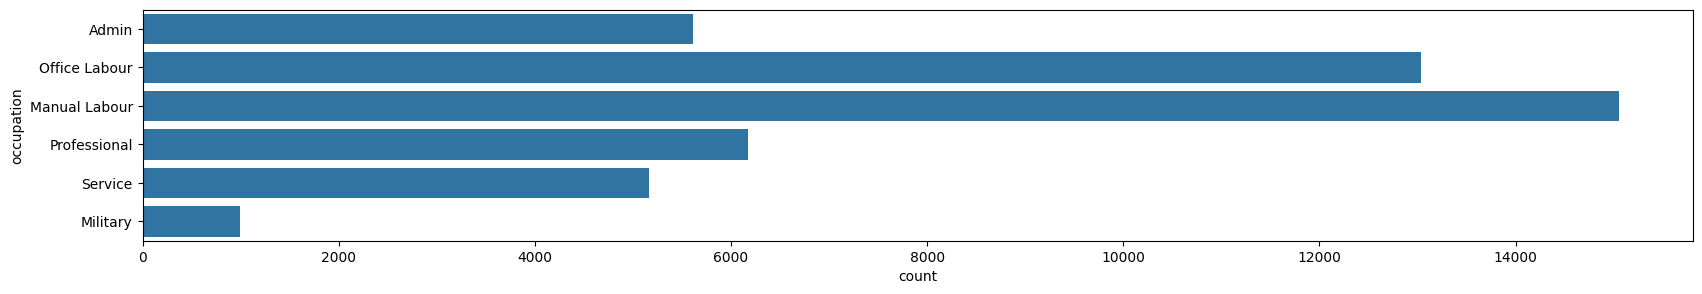

In [29]:
fig = plt.figure(figsize=(20,3))
sns.countplot(y="occupation", data=dataset_bin);

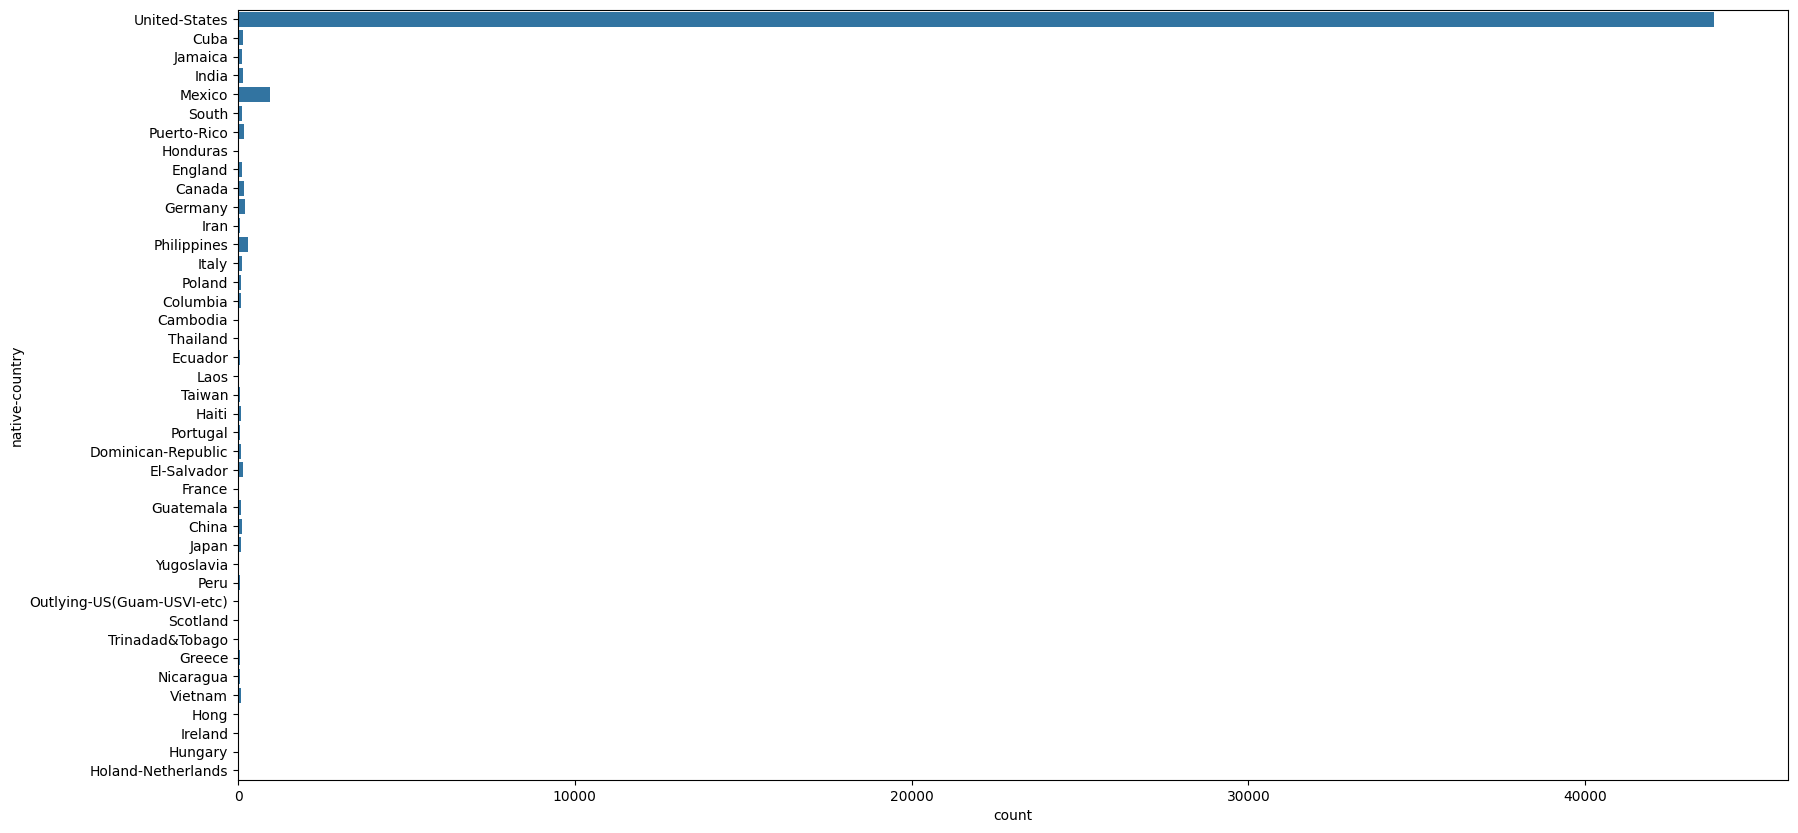

In [30]:
plt.figure(figsize=(20,10))
sns.countplot(y="native-country", data=dataset_raw);

In [31]:
dataset_raw.loc[dataset_raw['native-country'] == 'Cambodia'                    , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Canada'                      , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'China'                       , 'native-country'] = 'China'
dataset_raw.loc[dataset_raw['native-country'] == 'Columbia'                    , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Cuba'                        , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Dominican-Republic'          , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Ecuador'                     , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'El-Salvador'                 , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'England'                     , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'France'                      , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Germany'                     , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Greece'                      , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Guatemala'                   , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Haiti'                       , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Holand-Netherlands'          , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Honduras'                    , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Hong'                        , 'native-country'] = 'China'
dataset_raw.loc[dataset_raw['native-country'] == 'Hungary'                     , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'India'                       , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'Iran'                        , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Ireland'                     , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'Italy'                       , 'native-country'] = 'Euro_Group_1'
dataset_raw.loc[dataset_raw['native-country'] == 'Jamaica'                     , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Japan'                       , 'native-country'] = 'APAC'
dataset_raw.loc[dataset_raw['native-country'] == 'Laos'                        , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Mexico'                      , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Nicaragua'                   , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Outlying-US(Guam-USVI-etc)'  , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Peru'                        , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Philippines'                 , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Poland'                      , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Portugal'                    , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Puerto-Rico'                 , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'Scotland'                    , 'native-country'] = 'British-Commonwealth'
dataset_raw.loc[dataset_raw['native-country'] == 'South'                       , 'native-country'] = 'Euro_Group_2'
dataset_raw.loc[dataset_raw['native-country'] == 'Taiwan'                      , 'native-country'] = 'China'
dataset_raw.loc[dataset_raw['native-country'] == 'Thailand'                    , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Trinadad&Tobago'             , 'native-country'] = 'South-America'
dataset_raw.loc[dataset_raw['native-country'] == 'United-States'               , 'native-country'] = 'United-States'
dataset_raw.loc[dataset_raw['native-country'] == 'Vietnam'                     , 'native-country'] = 'SE-Asia'
dataset_raw.loc[dataset_raw['native-country'] == 'Yugoslavia'                  , 'native-country'] = 'Euro_Group_2'

dataset_bin['native-country'] = dataset_raw['native-country']
dataset_con['native-country'] = dataset_raw['native-country']

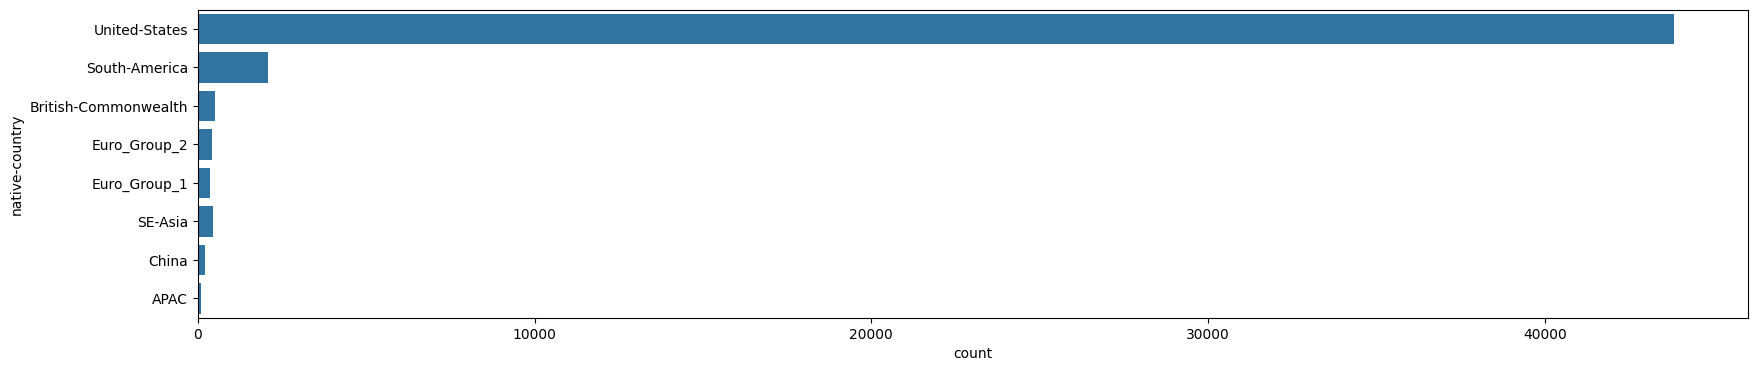

In [32]:
fig = plt.figure(figsize=(20,4))
sns.countplot(y="native-country", data=dataset_bin);

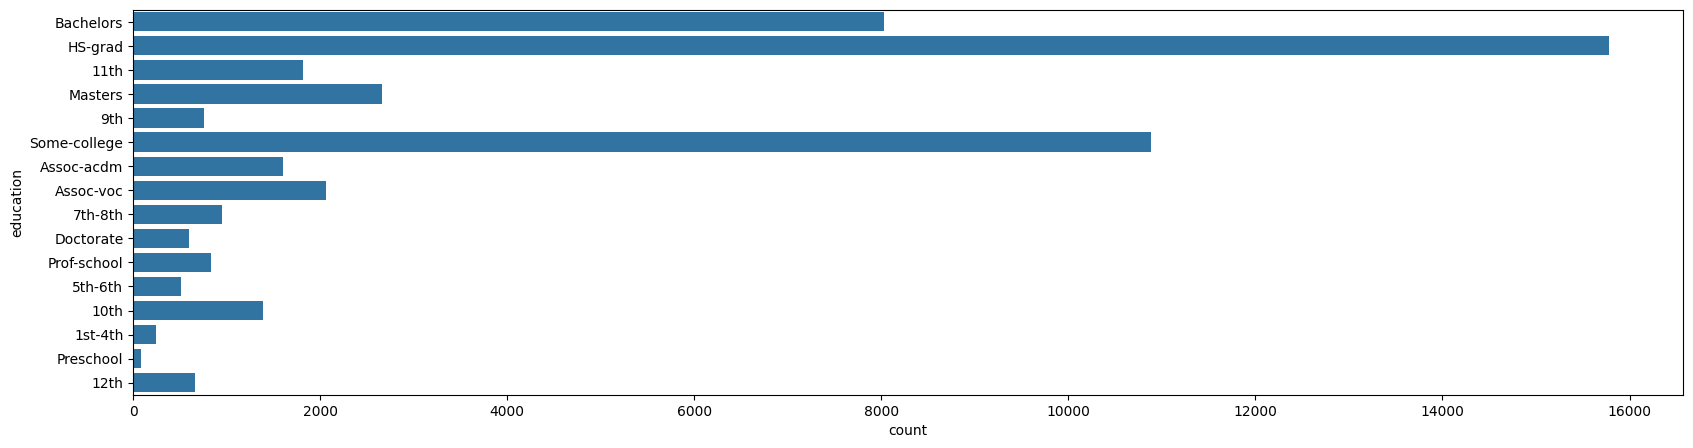

In [33]:
plt.figure(figsize=(20,5))
sns.countplot(y="education", data=dataset_raw);

In [34]:
dataset_raw.loc[dataset_raw['education'] == '10th'          , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '11th'          , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '12th'          , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '1st-4th'       , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '5th-6th'       , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '7th-8th'       , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == '9th'           , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == 'Assoc-acdm'    , 'education'] = 'Associate'
dataset_raw.loc[dataset_raw['education'] == 'Assoc-voc'     , 'education'] = 'Associate'
dataset_raw.loc[dataset_raw['education'] == 'Bachelors'     , 'education'] = 'Bachelors'
dataset_raw.loc[dataset_raw['education'] == 'Doctorate'     , 'education'] = 'Doctorate'
dataset_raw.loc[dataset_raw['education'] == 'HS-Grad'       , 'education'] = 'HS-Graduate'
dataset_raw.loc[dataset_raw['education'] == 'Masters'       , 'education'] = 'Masters'
dataset_raw.loc[dataset_raw['education'] == 'Preschool'     , 'education'] = 'Dropout'
dataset_raw.loc[dataset_raw['education'] == 'Prof-school'   , 'education'] = 'Professor'
dataset_raw.loc[dataset_raw['education'] == 'Some-college'  , 'education'] = 'HS-Graduate'

dataset_bin['education'] = dataset_raw['education']
dataset_con['education'] = dataset_raw['education']

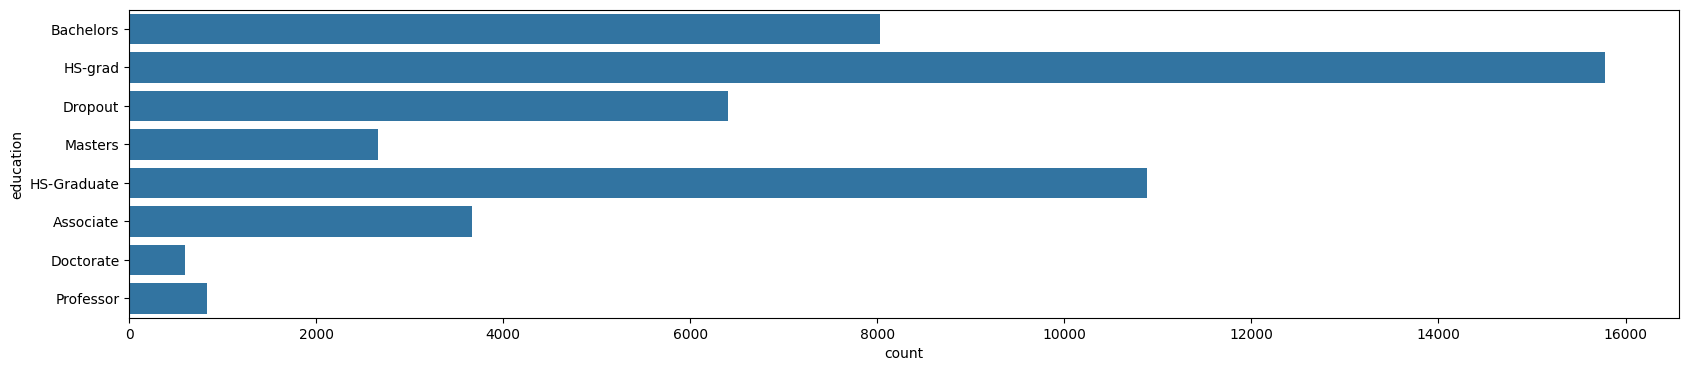

In [35]:
fig = plt.figure(figsize=(20,4))
sns.countplot(y="education", data=dataset_bin);

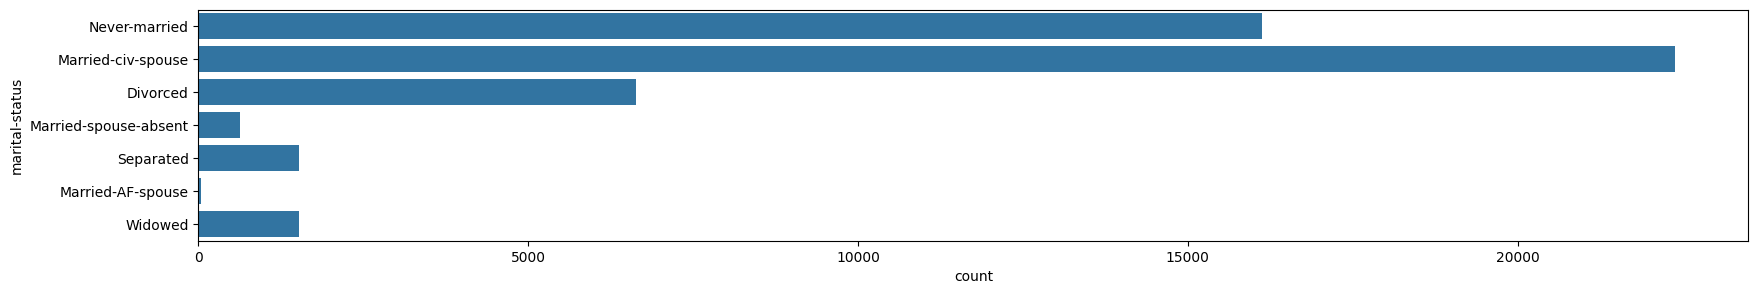

In [36]:
plt.figure(figsize=(20,3))
sns.countplot(y="marital-status", data=dataset_raw);

In [37]:
dataset_raw.loc[dataset_raw['marital-status'] == 'Never-married'        , 'marital-status'] = 'Never-Married'
dataset_raw.loc[dataset_raw['marital-status'] == 'Married-AF-spouse'    , 'marital-status'] = 'Married'
dataset_raw.loc[dataset_raw['marital-status'] == 'Married-civ-spouse'   , 'marital-status'] = 'Married'
dataset_raw.loc[dataset_raw['marital-status'] == 'Married-spouse-absent', 'marital-status'] = 'Not-Married'
dataset_raw.loc[dataset_raw['marital-status'] == 'Separated'            , 'marital-status'] = 'Separated'
dataset_raw.loc[dataset_raw['marital-status'] == 'Divorced'             , 'marital-status'] = 'Separated'
dataset_raw.loc[dataset_raw['marital-status'] == 'Widowed'              , 'marital-status'] = 'Widowed'

dataset_bin['marital-status'] = dataset_raw['marital-status']
dataset_con['marital-status'] = dataset_raw['marital-status']

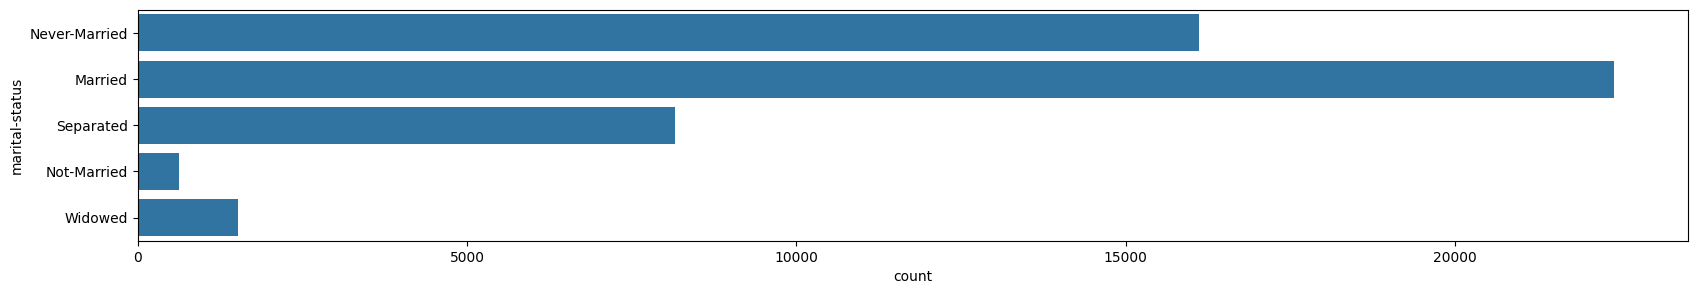

In [38]:
fig = plt.figure(figsize=(20,3))
sns.countplot(y="marital-status", data=dataset_bin);

In [39]:
dataset_bin['fnlwgt'] = pd.cut(dataset_raw['fnlwgt'], 10)
dataset_con['fnlwgt'] = dataset_raw['fnlwgt']

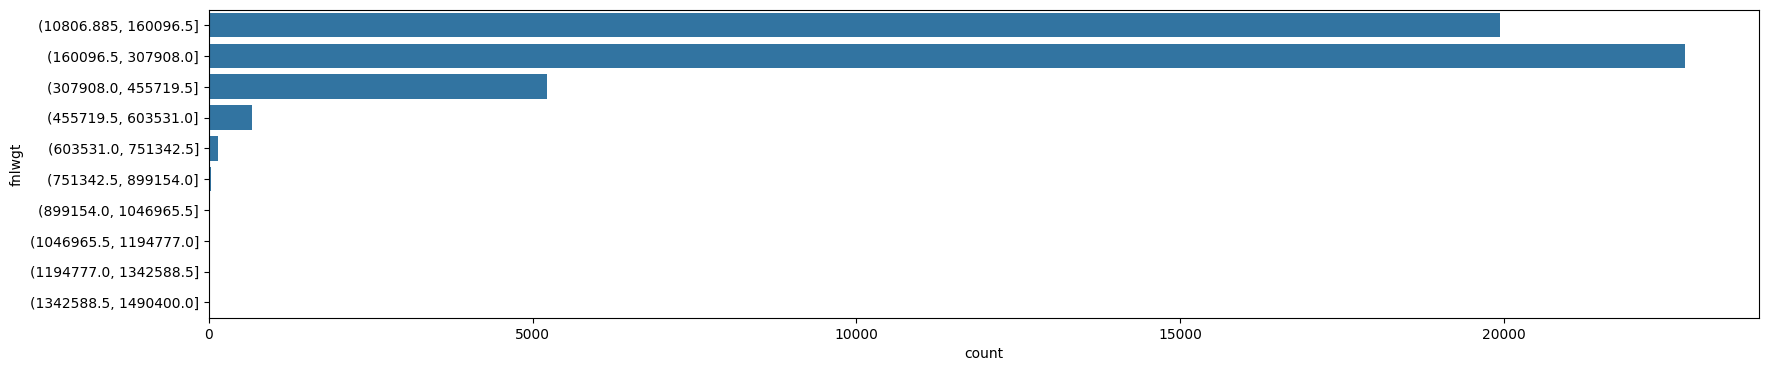

In [40]:
fig = plt.figure(figsize=(20,4))
sns.countplot(y="fnlwgt", data=dataset_bin);

<Axes: xlabel='count', ylabel='education-num'>

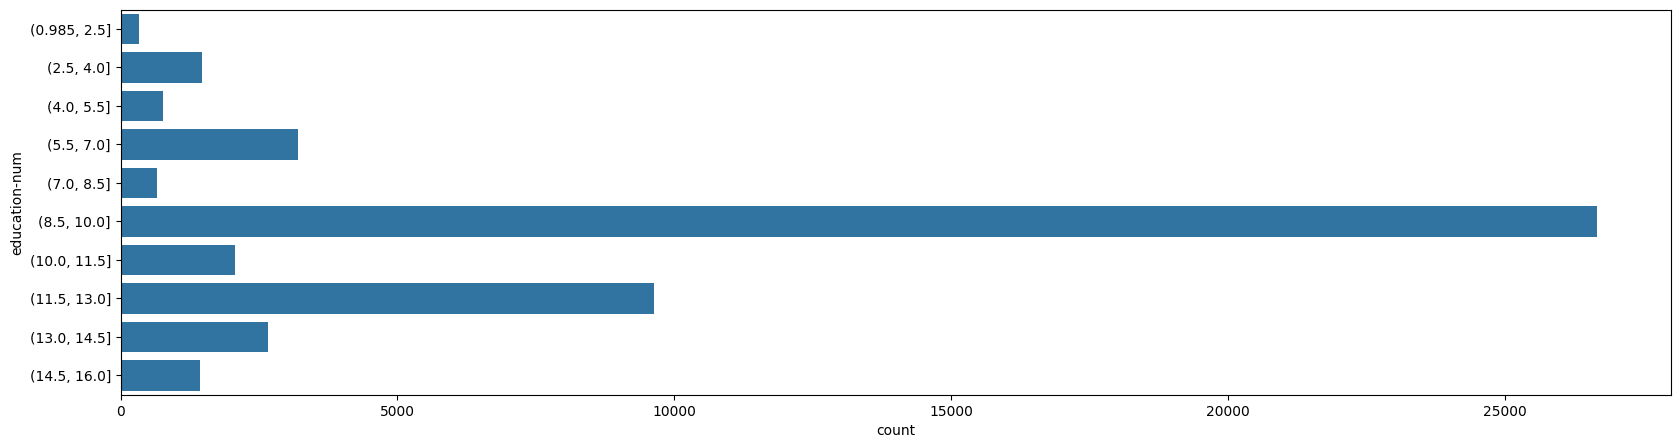

In [41]:
dataset_bin['education-num'] = pd.cut(dataset_raw['education-num'], 10)
dataset_con['education-num'] = dataset_raw['education-num']

fig = plt.figure(figsize=(20,5))
sns.countplot(y="education-num", data=dataset_bin)

<Axes: xlabel='hours-per-week', ylabel='Density'>

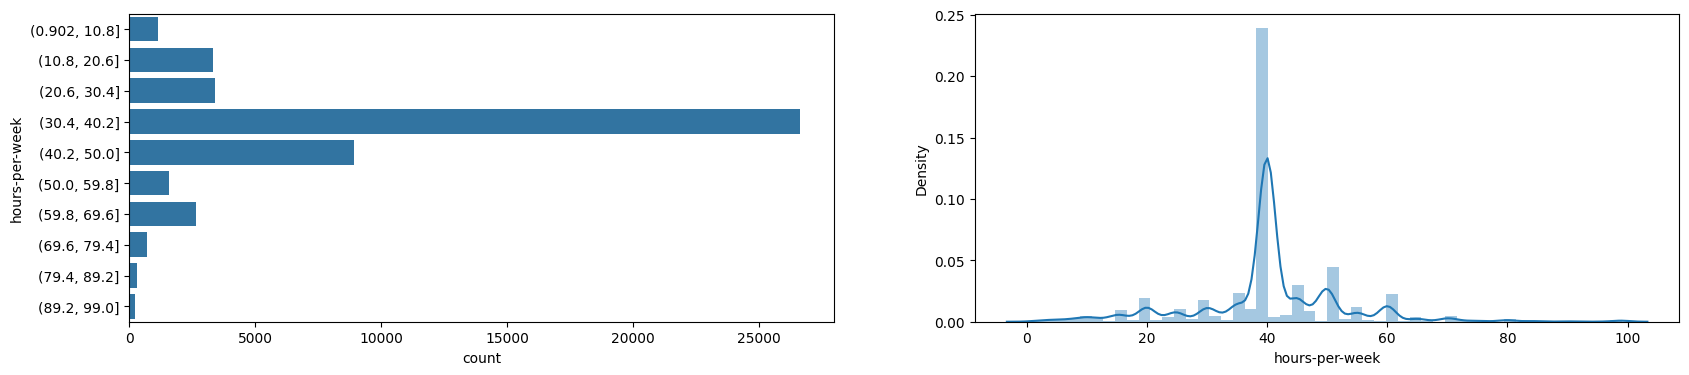

In [42]:
dataset_bin['hours-per-week'] = pd.cut(dataset_raw['hours-per-week'], 10)
dataset_con['hours-per-week'] = dataset_raw['hours-per-week']

fig = plt.figure(figsize=(20,4))
plt.subplot(1, 2, 1)
sns.countplot(y="hours-per-week", data=dataset_bin)
plt.subplot(1, 2, 2)
sns.distplot(dataset_con['hours-per-week'])

<Axes: xlabel='capital-gain', ylabel='Density'>

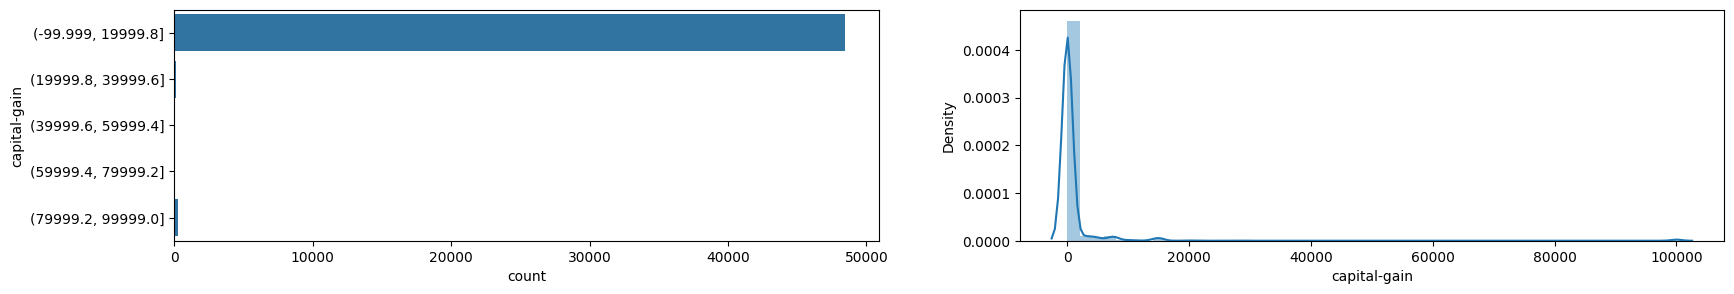

In [43]:
dataset_bin['capital-gain'] = pd.cut(dataset_raw['capital-gain'], 5)
dataset_con['capital-gain'] = dataset_raw['capital-gain']

fig = plt.figure(figsize=(20,3))
plt.subplot(1, 2, 1)
sns.countplot(y="capital-gain", data=dataset_bin)
plt.subplot(1, 2, 2)
sns.distplot(dataset_con['capital-gain'])

<Axes: xlabel='capital-loss', ylabel='Density'>

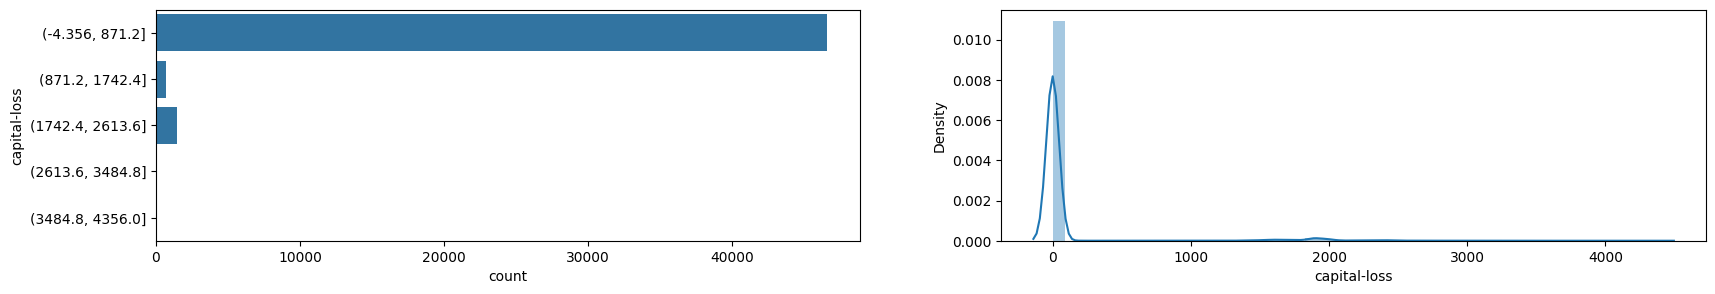

In [44]:
dataset_bin['capital-loss'] = pd.cut(dataset_raw['capital-loss'], 5)
dataset_con['capital-loss'] = dataset_raw['capital-loss']

fig = plt.figure(figsize=(20,3))
plt.subplot(1, 2, 1)
sns.countplot(y="capital-loss", data=dataset_bin)
plt.subplot(1, 2, 2)
sns.distplot(dataset_con['capital-loss'])

Anteriormente agarramos muchos de los _features_ de nuestros datos y los transformamos de una u otra forma, ya sea aplicando nuevos buckets, utilizando el método cut de pandas, entre otros, sin embargo, viendo los datos nos damos cuenta que otros features están lo suficientemente bien como para simplemente pasarlos al análisis, así que simplemente copiamos su valor

In [45]:
# Some features we'll consider to be in good enough shape as to pass through
dataset_con['sex'] = dataset_bin['sex'] = dataset_raw['sex']
dataset_con['race'] = dataset_bin['race'] = dataset_raw['race']
dataset_con['relationship'] = dataset_bin['relationship'] = dataset_raw['relationship']

De momento estuvimos revisando variables individualmente, ahora hagamos combinaciones y veamos que descrubrimos en los datos

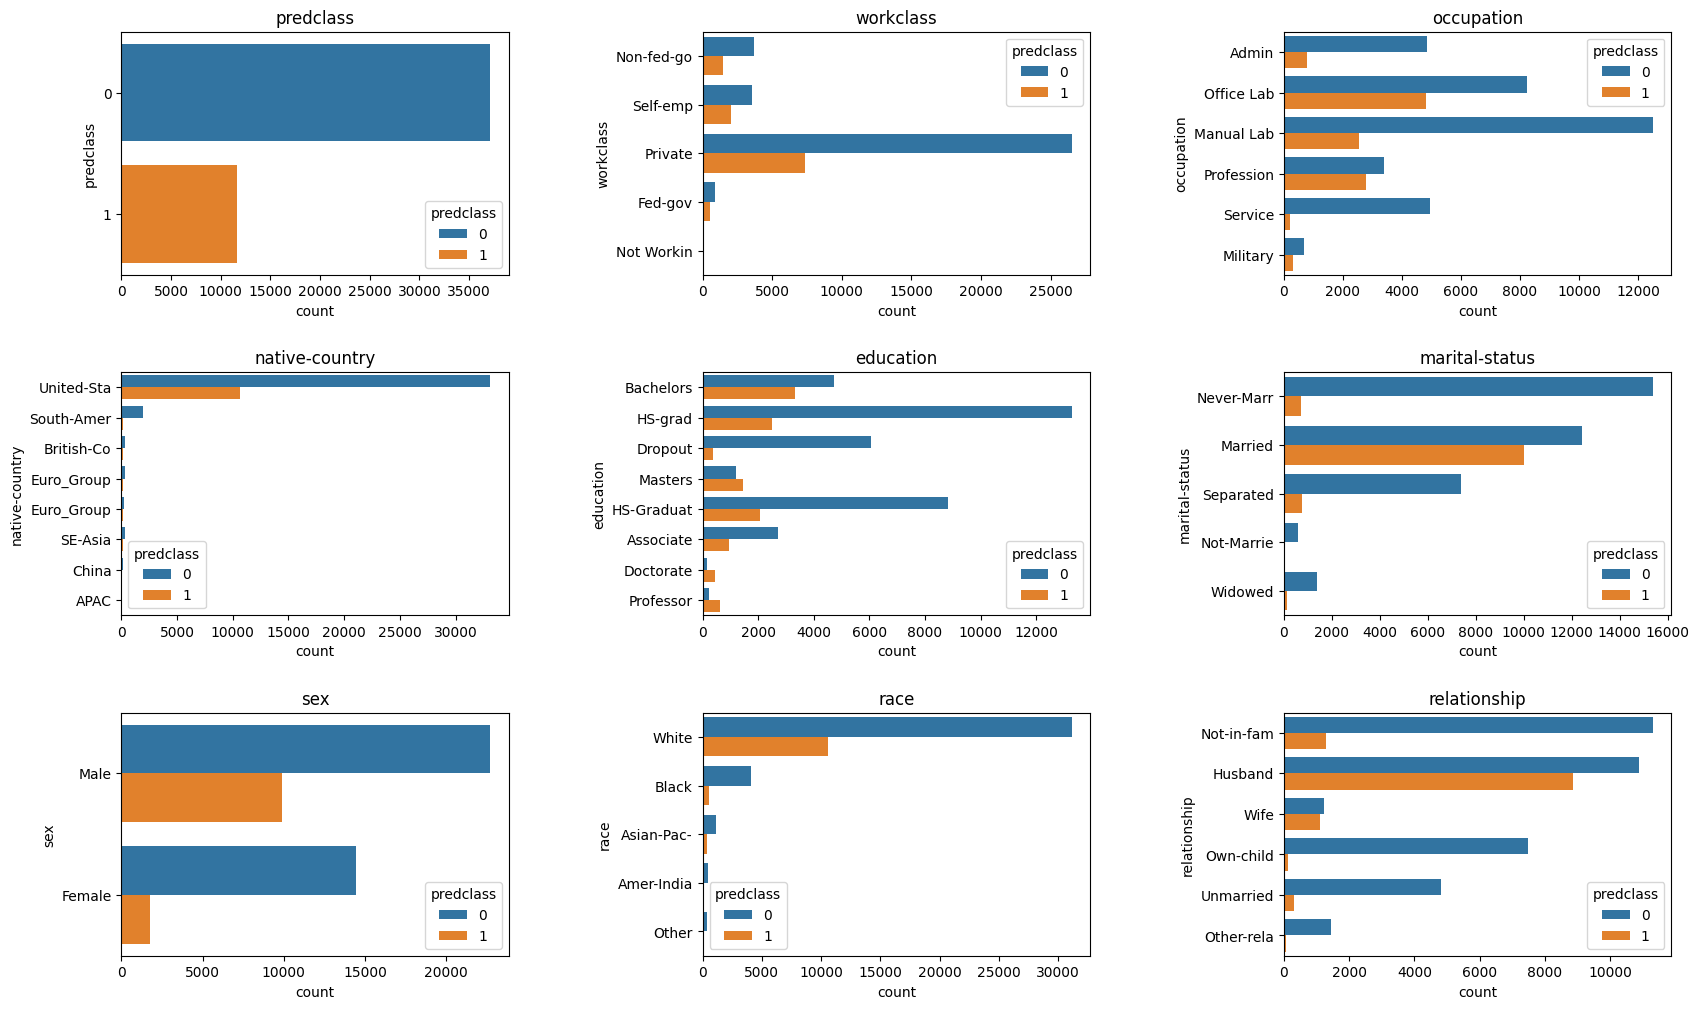

In [46]:
# Plot a count of the categories from each categorical feature split by our prediction class: salary - predclass.
def plot_bivariate_bar(dataset, hue, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    dataset = dataset.select_dtypes(include=[object])
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == object:
            g = sns.countplot(y=column, hue=hue, data=dataset)
            substrings = [s.get_text()[:10] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)

plot_bivariate_bar(dataset_con, hue='predclass', cols=3, width=20, height=12, hspace=0.4, wspace=0.5)

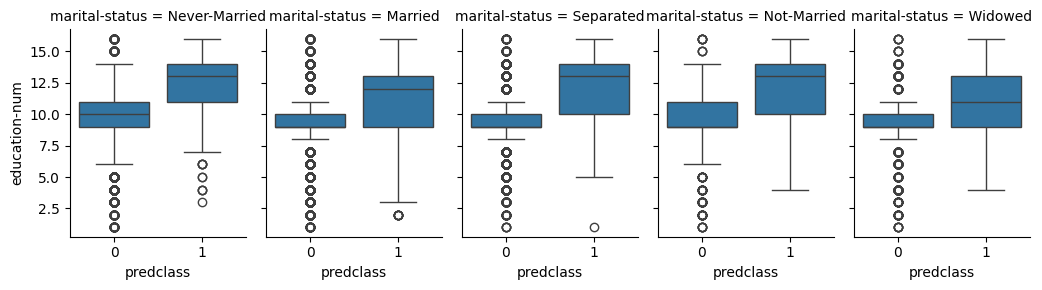

In [47]:
# Efecto del estatus marital y educación en el salario
g = sns.FacetGrid(dataset_con, col='marital-status', aspect=.7)
g = g.map(sns.boxplot, 'predclass', 'education-num')

<Axes: xlabel='sex', ylabel='age'>

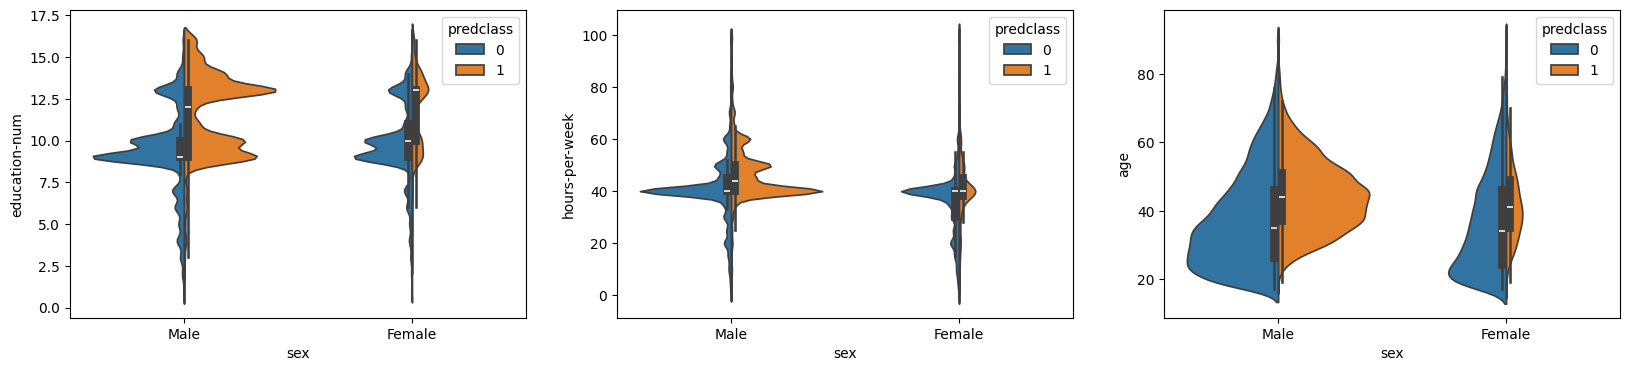

In [48]:
fig = plt.figure(figsize=(20,4))
plt.subplot(1, 3, 1)
sns.violinplot(x='sex', y='education-num', hue='predclass', data=dataset_con, split=True, scale='count')

plt.subplot(1, 3, 2)
sns.violinplot(x='sex', y='hours-per-week', hue='predclass', data=dataset_con, split=True, scale='count')

plt.subplot(1, 3, 3)
sns.violinplot(x='sex', y='age', hue='predclass', data=dataset_con, split=True, scale='count')

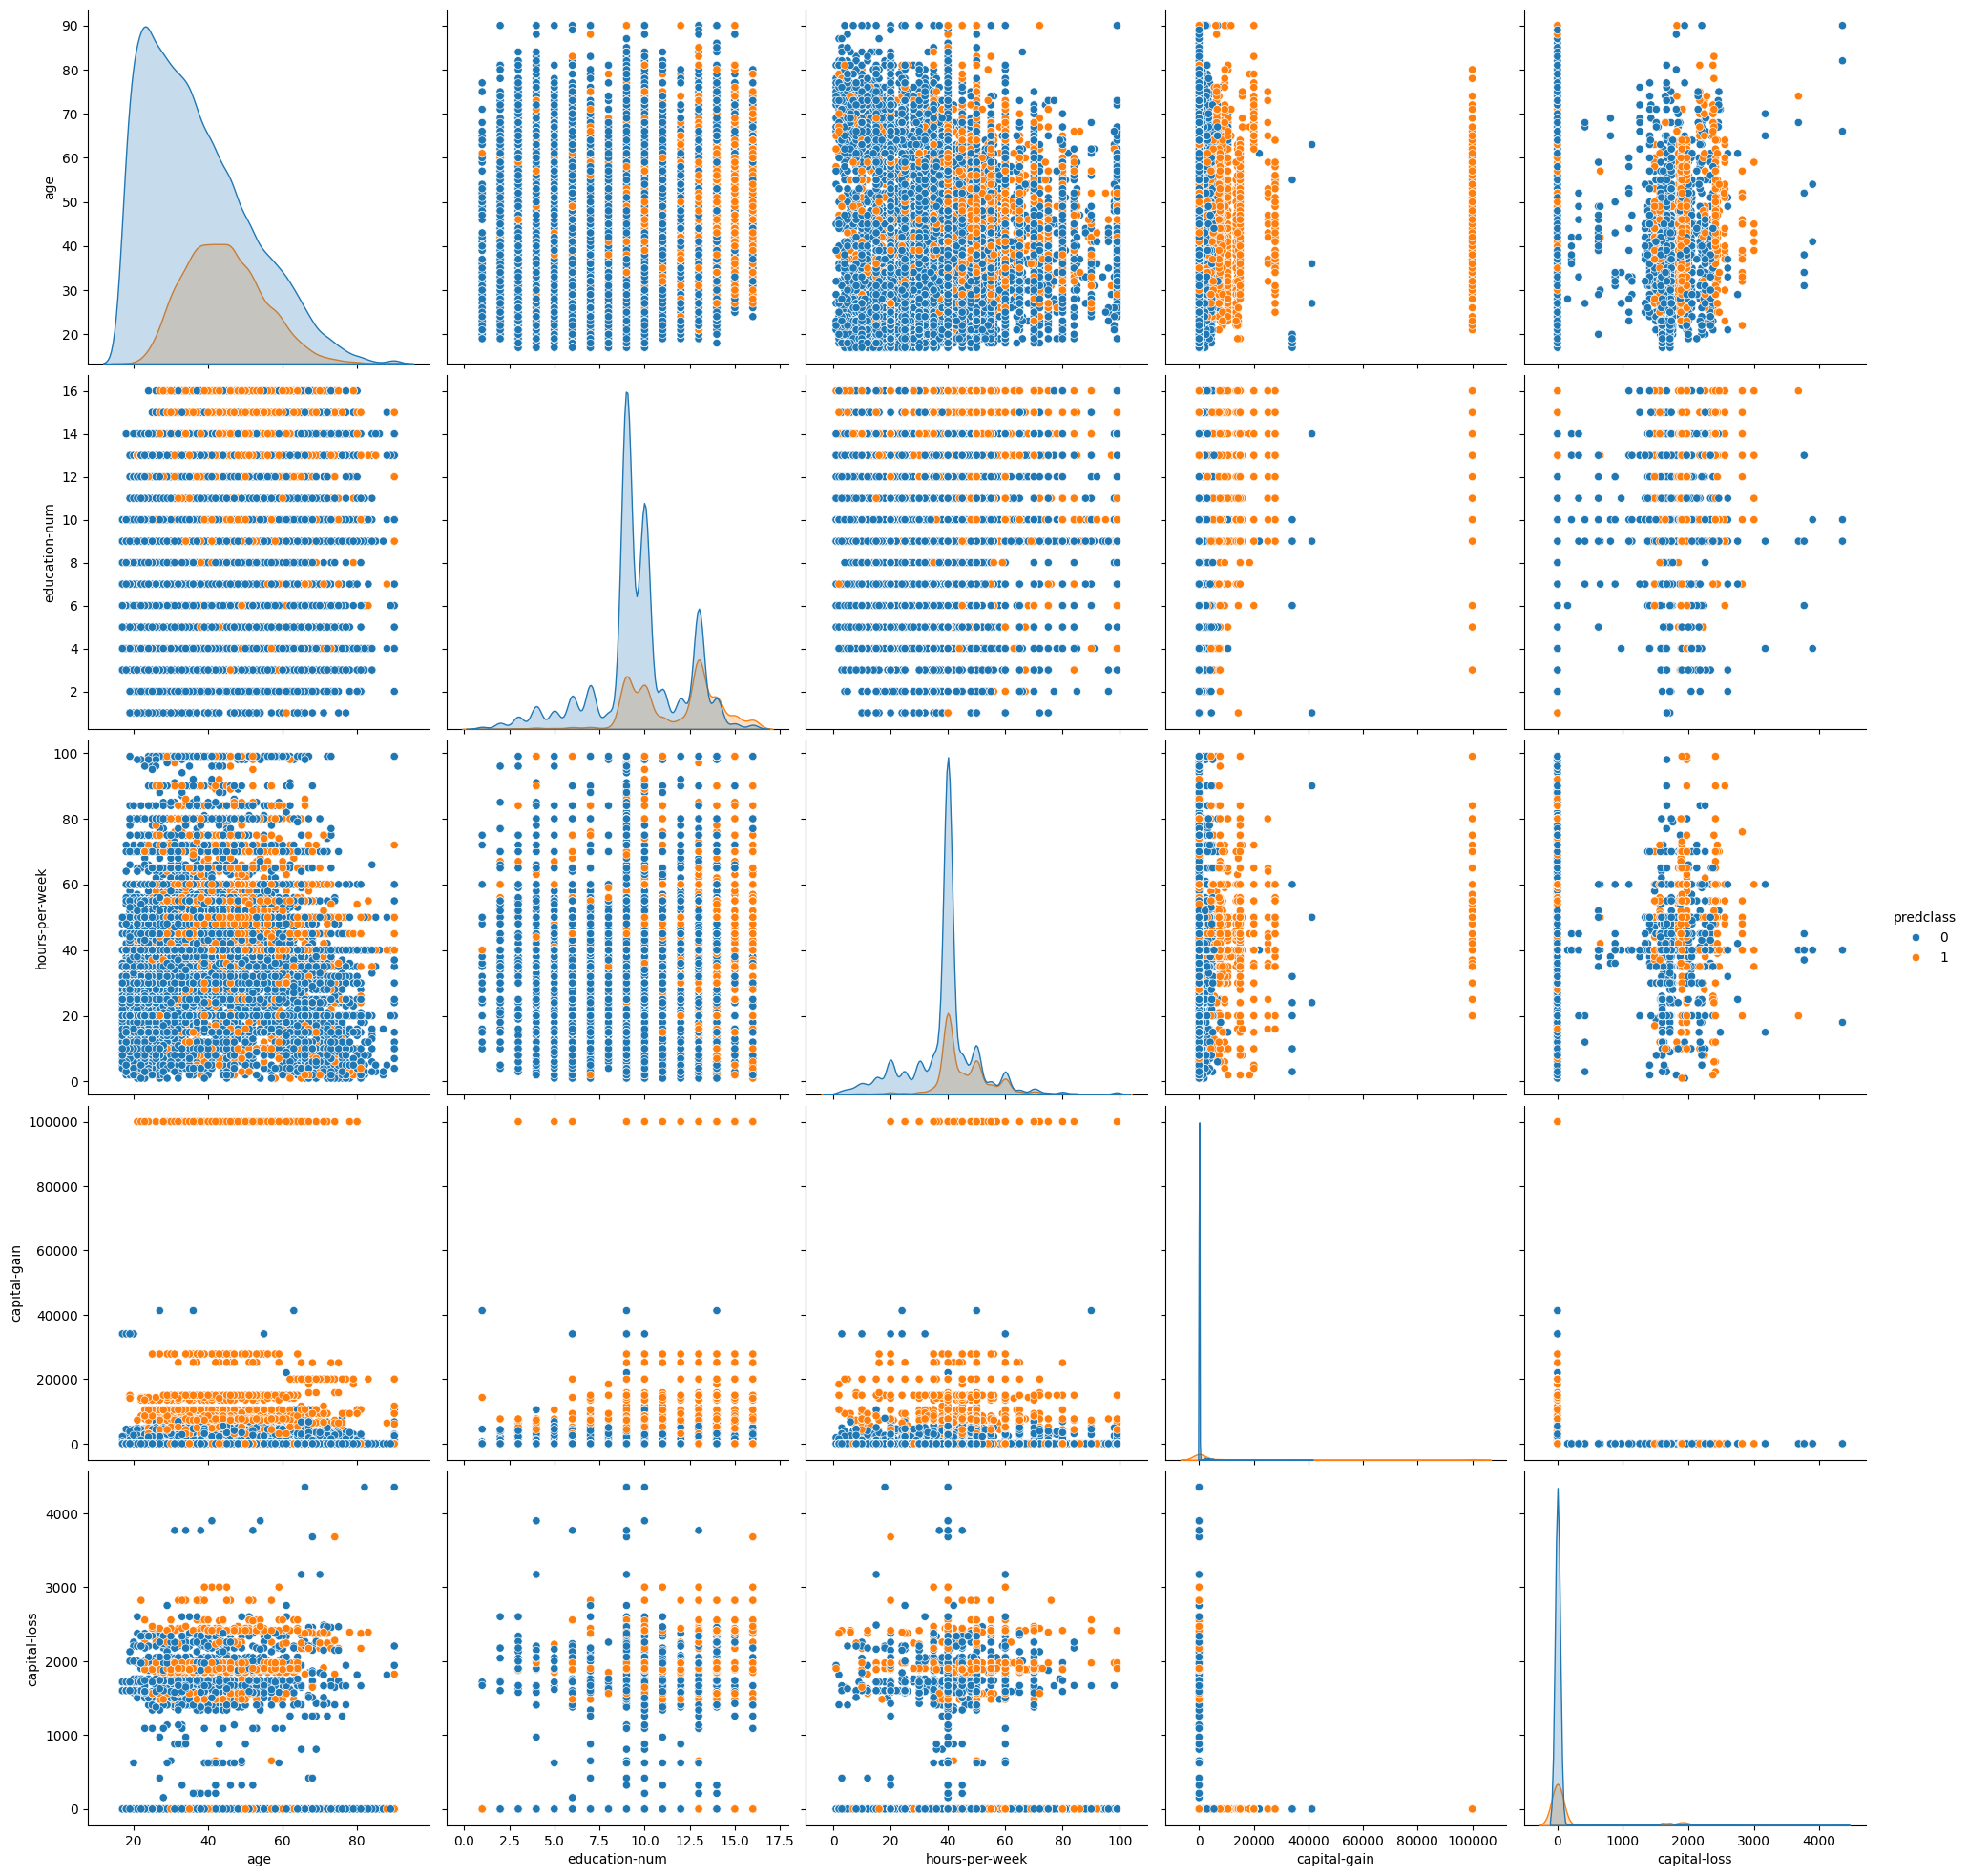

In [49]:
sns.pairplot(dataset_con[['age','education-num','hours-per-week','predclass','capital-gain','capital-loss']],
             hue="predclass",
             diag_kind="kde",
             size=4);

Anteriormente modificamos y limpiamos los _features_ que teniamos en nuestra data, ahora podemos añadir nuevos features de acuerdo a nuestro conocimiento humano

<Axes: xlabel='age-hours', ylabel='Density'>

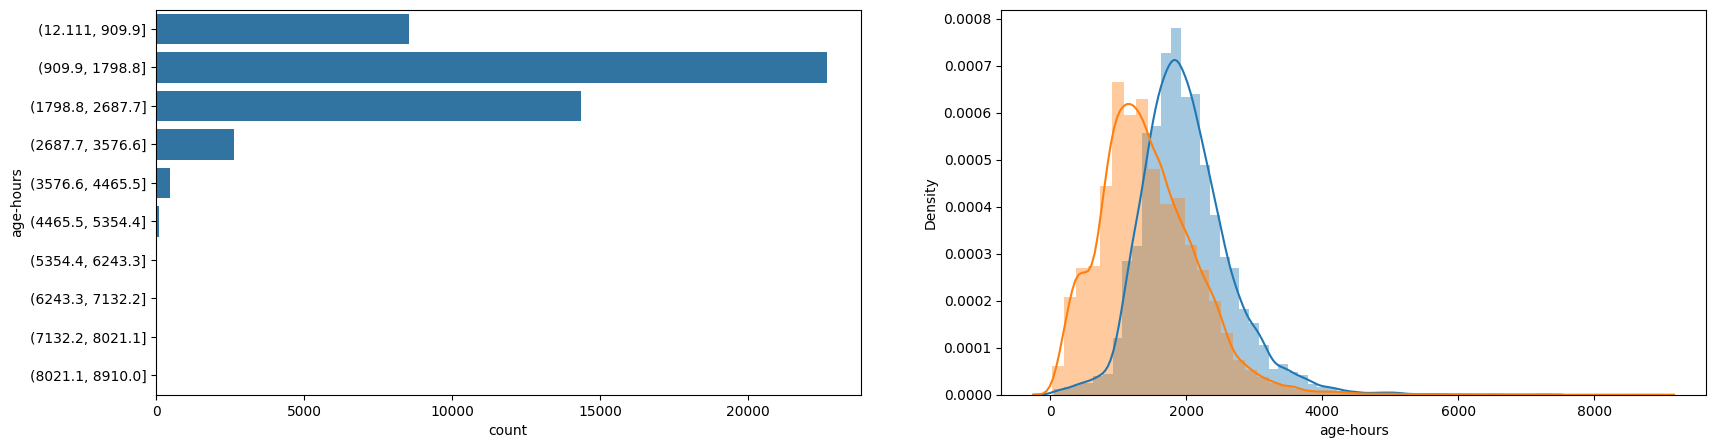

In [50]:
# Crossing Numerical Features
dataset_con['age-hours'] = dataset_con['age'] * dataset_con['hours-per-week']

dataset_bin['age-hours'] = pd.cut(dataset_con['age-hours'], 10)
dataset_con['age-hours'] = dataset_con['age-hours']

fig = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.countplot(y="age-hours", data=dataset_bin)
plt.subplot(1, 2, 2)
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 1]['age-hours'], kde_kws={"label": ">$50K"})
sns.distplot(dataset_con.loc[dataset_con['predclass'] == 0]['age-hours'], kde_kws={"label": "<$50K"})

<Axes: xlabel='count', ylabel='sex-marital'>

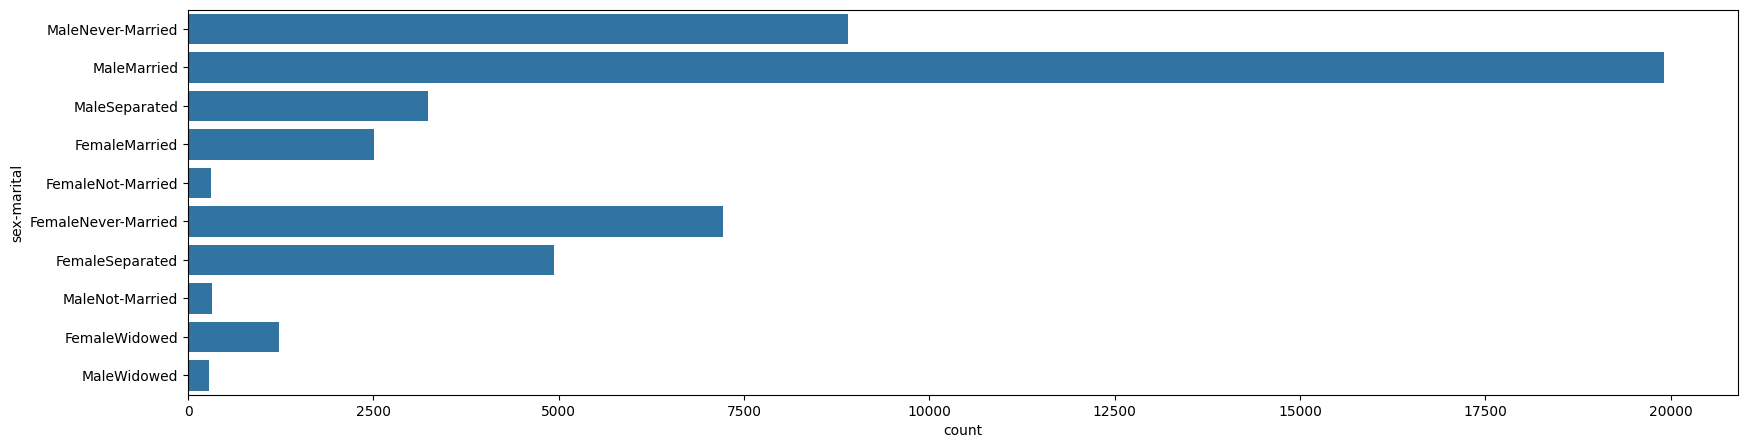

In [51]:
# Crossing Categorical Features
dataset_bin['sex-marital'] = dataset_con['sex-marital'] = dataset_con['sex'] + dataset_con['marital-status']

fig = plt.figure(figsize=(20,5))
sns.countplot(y="sex-marital", data=dataset_bin)

# Feature encoding
Cuando hablamos de machine learning hablamos de algoritmos que realizan operaciones de algebra lineal en matrices. Esto nos obliga a que todos los features (o celdas de la matriz) contengan dato numéricos. El proceso de convertir _features_ categoricos a valores numéricos se le llama encoding

In [53]:
one_hot_cols = dataset_bin.columns.tolist()
one_hot_cols.remove('predclass')
dataset_bin_enc = pd.get_dummies(dataset_bin, columns=one_hot_cols)

dataset_bin_enc.head()

predclass  age_(16.927, 24.3]  age_(24.3, 31.6]  age_(31.6, 38.9]  \
0         0               False             False             False   
1         0               False             False             False   
2         0               False             False              True   
3         0               False             False             False   
4         0               False              True             False   

   age_(38.9, 46.2]  age_(46.2, 53.5]  age_(53.5, 60.8]  age_(60.8, 68.1]  \
0              True             False             False             False   
1             False              True             False             False   
2             False             False             False             False   
3             False              True             False             False   
4             False             False             False             False   

   age_(68.1, 75.4]  age_(75.4, 82.7]  ...  sex-marital_FemaleMarried  \
0             False             False  ...                      False   
1             False             False  ...                      False   
2             False             False  ...                      False   
3             False             False  ...                      False   
4             False             False  ...                       True   

   sex-marital_FemaleNever-Married  sex-marital_FemaleNot-Married  \
0                            False                          False   
1                            False                          False   
2                            False                          False   
3                            False                          False   
4                            False                          False   

   sex-marital_FemaleSeparated  sex-marital_FemaleWidowed  \
0                        False                      False   
1                        False                      False   
2                        False                      False   
3                        False                      False   
4                        False                      False   

   sex-marital_MaleMarried  sex-marital_MaleNever-Married  \
0                    False                           True   
1                     True                          False   
2                    False                          False   
3                     True                          False   
4                    False                          False   

   sex-marital_MaleNot-Married  sex-marital_MaleSeparated  \
0                        False                      False   
1                        False                      False   
2                        False                       True   
3                        False                      False   
4                        False                      False   

   sex-marital_MaleWidowed  
0                    False  
1                    False  
2                    False  
3                    False  
4                    False  

[5 rows x 116 columns]

In [54]:
# Label Encode all labels
dataset_con_enc = dataset_con.apply(LabelEncoder().fit_transform)

dataset_con_enc.head()

predclass  age  workclass  occupation  native-country  education  \
0          0   22          1           0               7          1   
1          0   33          4           3               7          1   
2          0   21          3           1               7          5   
3          0   36          3           1               7          3   
4          0   11          3           4               6          1   

   marital-status  fnlwgt  education-num  hours-per-week  capital-gain  \
0               1    3461             12              39            27   
1               0    3788             12              12             0   
2               3   18342              8              39             0   
3               0   19995              6              39             0   
4               0   25405             12              39             0   

   capital-loss  sex  race  relationship  age-hours  sex-marital  
0             0    1     4             1        695            6  
1             0    1     4             0        334            5  
2             0    1     4             1        683            8  
3             0    1     2             0        890            5  
4             0    0     2             5        530            0

# Feature Reduction / Selection
Como lo vimos la clase pasada hay ocasiones donde es mejor reducir la cantidad de features por el desempeño de nuestros algoritmos. Hay varias técnicas que podemos aplicar

- Reduccion de dimensionalidad
1. Principal Component Analysis (PCA): Es un procedimiento estadístico que convierte un set de variables correlacionadas entre sí en otro set nuevo lineal sin relación entre sí
2. Singular Value Decomposition (SVD): Descomponer o factorizar los valores reales o complejos de una matrix
- Importancia de los _features_
1. Filtros: Eliminar columnas que no esten relacionadas con la variable que buscamos predecir

# Correlación
Es una medida de que tanto dos variables cambian juntas. Un buen dataset tiene features *sin correlación entre sí* y *alta correlación* de cada feature con la variable que deseamos predecir

<Axes: >

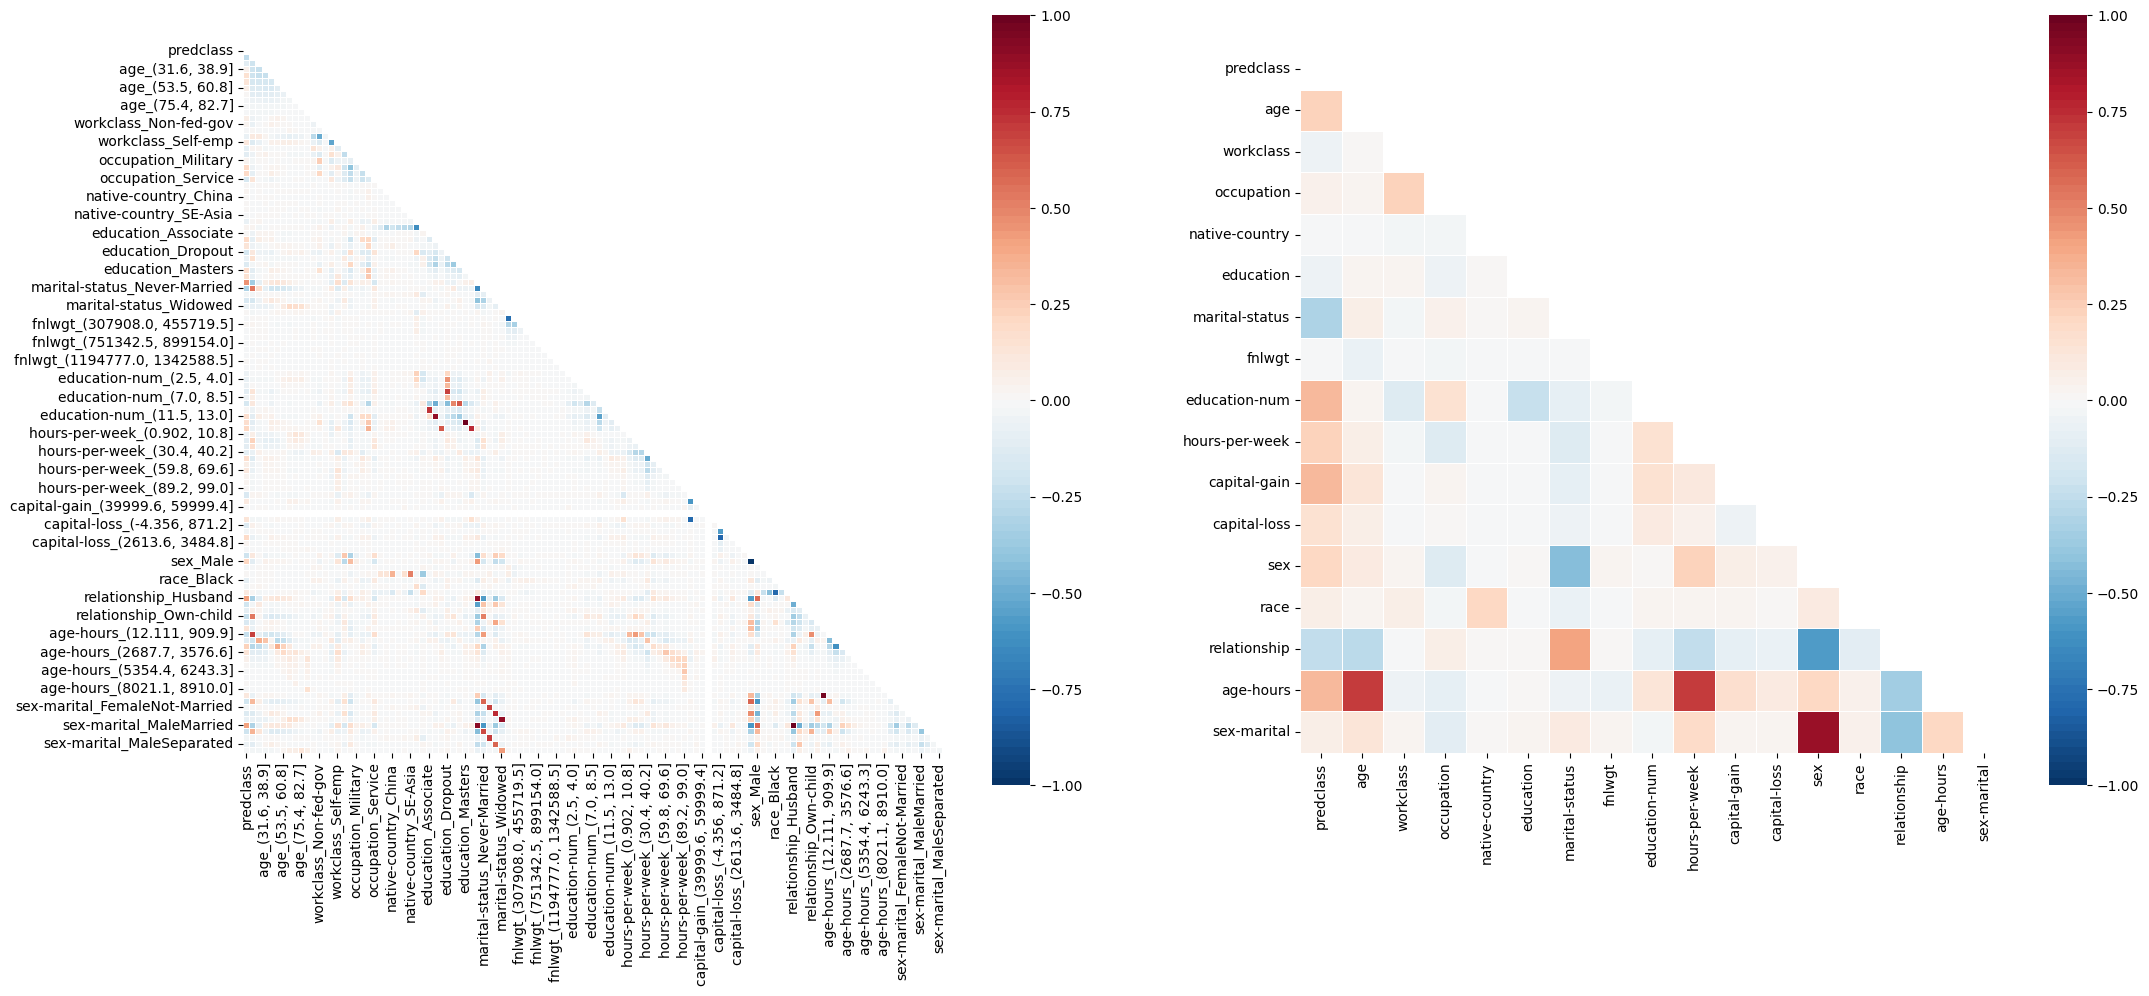

In [55]:
fig = plt.figure(figsize=(25,10))

plt.subplot(1, 2, 1)
# Generate a mask for the upper triangle
mask = np.zeros_like(dataset_bin_enc.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset_bin_enc.corr(),
            vmin=-1, vmax=1,
            square=True,
            cmap=sns.color_palette("RdBu_r", 100),
            mask=mask,
            linewidths=.5)

plt.subplot(1, 2, 2)
mask = np.zeros_like(dataset_con_enc.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset_con_enc.corr(),
            vmin=-1, vmax=1,
            square=True,
            cmap=sns.color_palette("RdBu_r", 100),
            mask=mask,
            linewidths=.5)

# Feature Importance
Random forest es un algoritmo de clasificación que consiste de multiples decision trees. Cada nodo en un decision tree representa una condición basada en un único feature. Cada nodo está diseñado para separar el dataset en 2 partes iguales. Entrenar un random forest o un arbol de decisión nos ayuda a identificar _features_ que separen los datos de forma adecuada

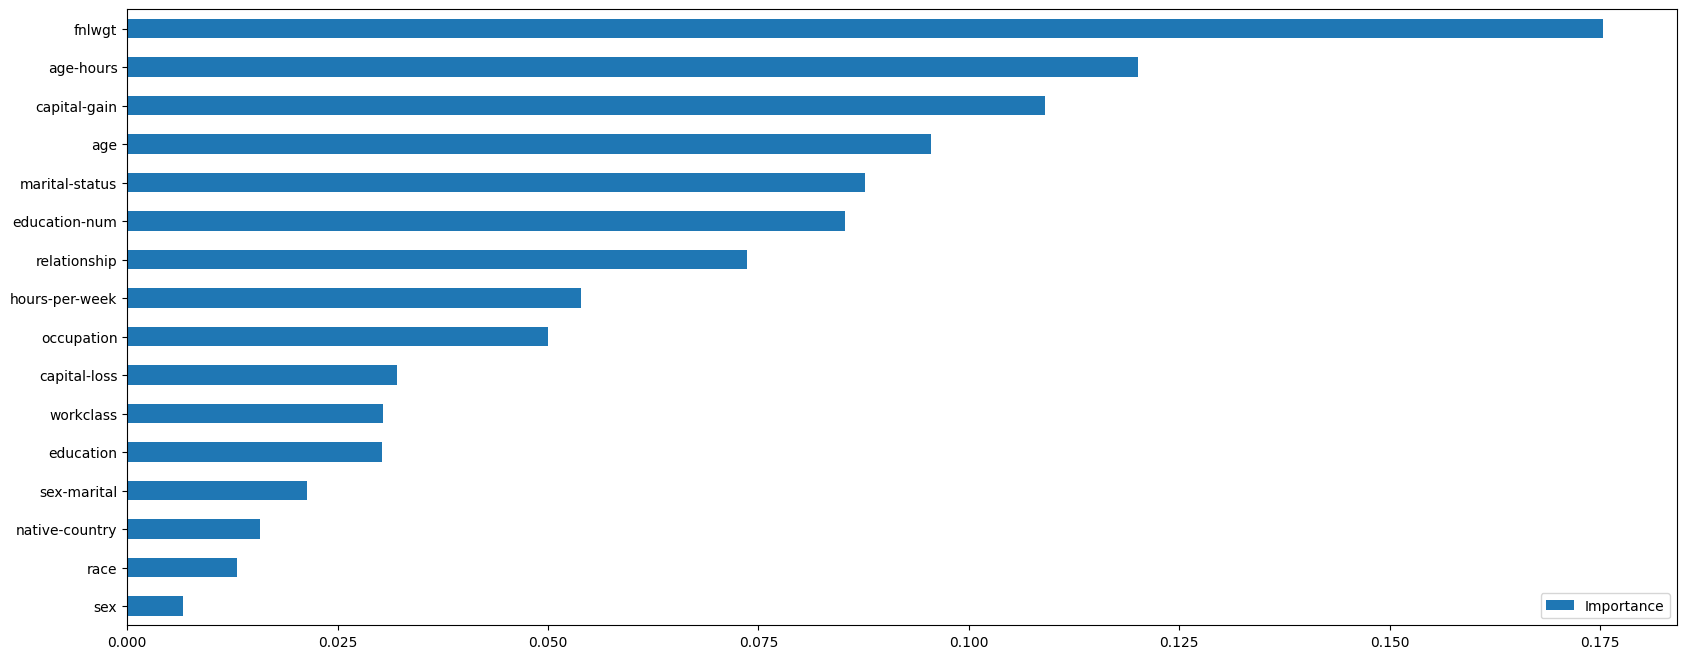

In [56]:
# Using Random Forest to gain an insight on Feature Importance
clf = RandomForestClassifier()
clf.fit(dataset_con_enc.drop('predclass', axis=1), dataset_con_enc['predclass'])

importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=dataset_con_enc.drop('predclass', axis=1).columns, columns=["Importance"])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importance)/2));

# PCA
Podemos usar PCA para reducir el número de features que necesitamos para representar nuestro dataset de forma adecuada. Recuerden que en un buen dataset nuestros _features_ no tienen correlación entre sí, pero cada _feature_ tiene alta correlación con la variable que intentamos predecir.
PCA nos ayuda a combinar _features_ que están altamente relacionados entre sí. Así eliminamos _features_ de nuestro análisis sin perder datos.

<BarContainer object of 15 artists>

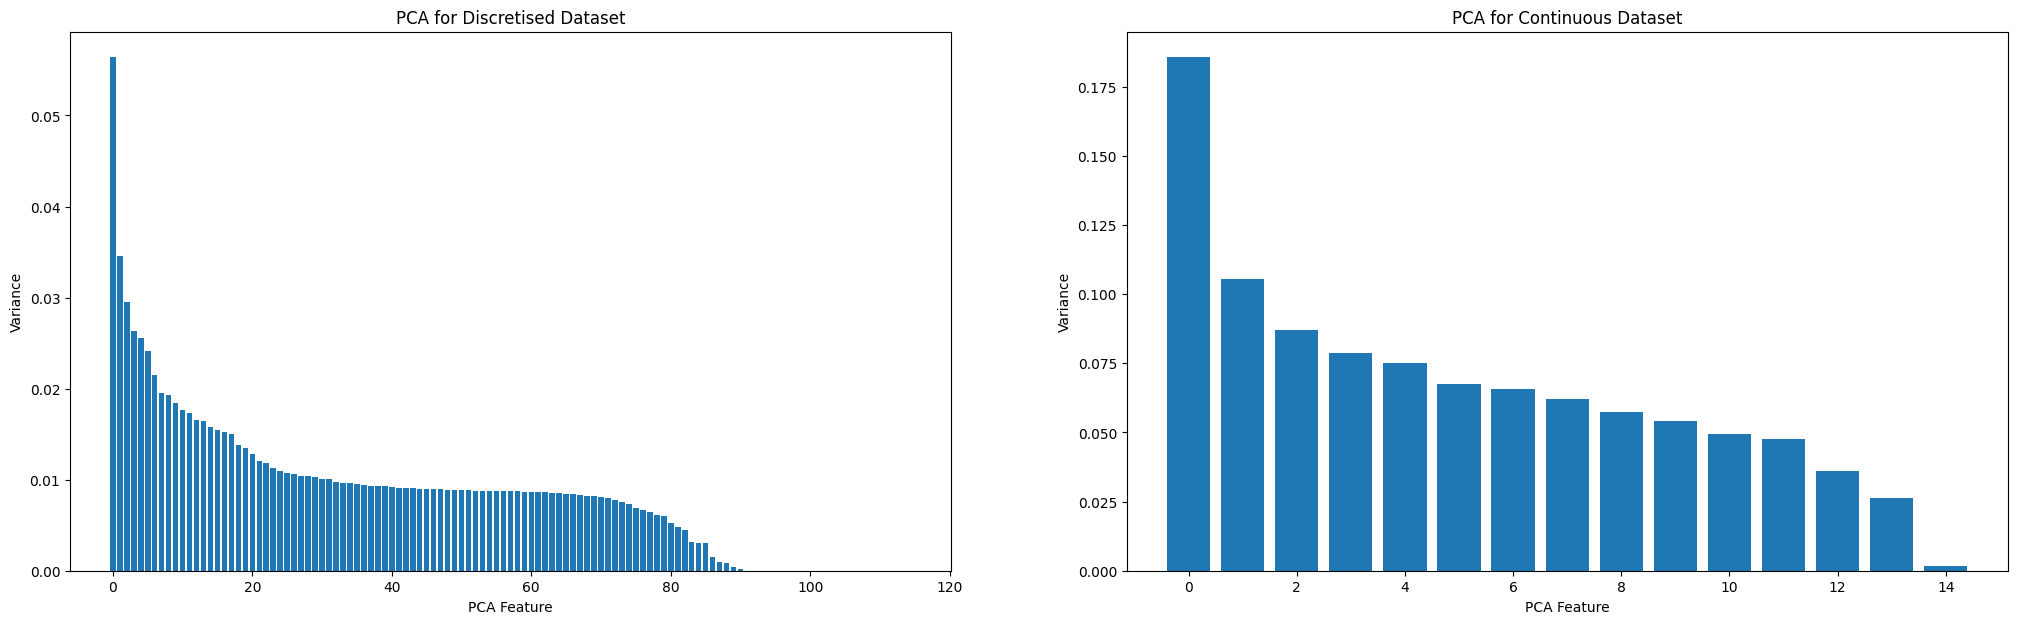

In [57]:
# Calculating PCA for both datasets, and graphing the Variance for each feature, per dataset
std_scale = preprocessing.StandardScaler().fit(dataset_bin_enc.drop('predclass', axis=1))
X = std_scale.transform(dataset_bin_enc.drop('predclass', axis=1))
pca1 = PCA(n_components=len(dataset_bin_enc.columns)-1)
fit1 = pca1.fit(X)

std_scale = preprocessing.StandardScaler().fit(dataset_con_enc.drop('predclass', axis=1))
X = std_scale.transform(dataset_con_enc.drop('predclass', axis=1))
pca2 = PCA(n_components=len(dataset_con_enc.columns)-2)
fit2 = pca2.fit(X)

# Graphing the variance per feature
plt.figure(figsize=(25,7))

plt.subplot(1, 2, 1)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Discretised Dataset')
plt.bar(range(0, fit1.explained_variance_ratio_.size), fit1.explained_variance_ratio_)

plt.subplot(1, 2, 2)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Continuous Dataset')
plt.bar(range(0, fit2.explained_variance_ratio_.size), fit2.explained_variance_ratio_)

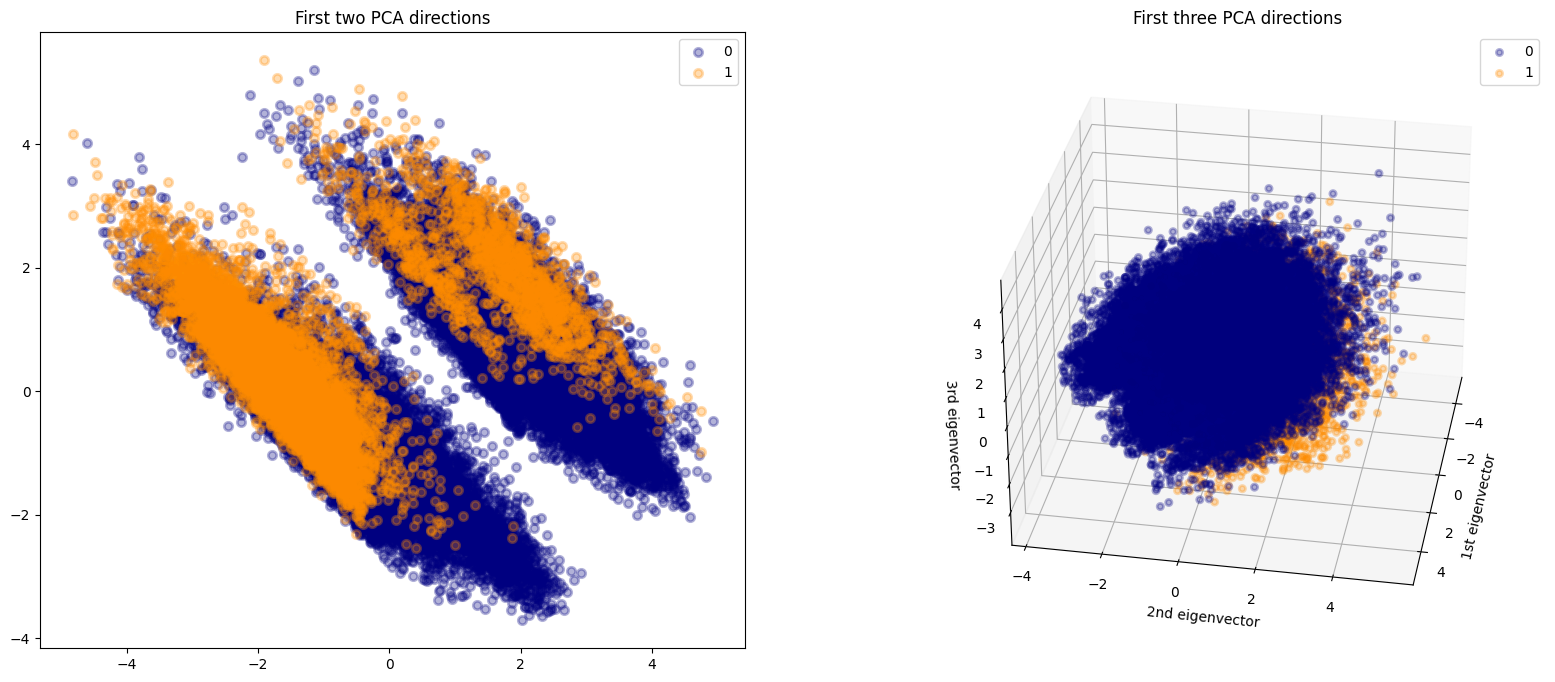

In [58]:
# PCA's components graphed in 2D and 3D
# Apply Scaling
std_scale = preprocessing.StandardScaler().fit(dataset_con_enc.drop('predclass', axis=1))
X = std_scale.transform(dataset_con_enc.drop('predclass', axis=1))
y = dataset_con_enc['predclass']

# Formatting
target_names = [0,1]
colors = ['navy','darkorange']
lw = 2
alpha = 0.3
# 2 Components PCA
plt.figure(2, figsize=(20, 8))

plt.subplot(1, 2, 1)
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1],
                color=color,
                alpha=alpha,
                lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('First two PCA directions')

# 3 Components PCA
ax = plt.subplot(1, 2, 2, projection='3d')

pca = PCA(n_components=3)
X_reduced = pca.fit(X).transform(X)
for color, i, target_name in zip(colors, [0, 1], target_names):
    ax.scatter(X_reduced[y == i, 0], X_reduced[y == i, 1], X_reduced[y == i, 2],
               color=color,
               alpha=alpha,
               lw=lw,
               label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
ax.set_zlabel("3rd eigenvector")

# rotate the axes
ax.view_init(30, 10)

# Recursive Feature Elimination
Vamos a crear un ranking para identificar la importancia de cada feature, basados en la importancia de cada feature podemos identificar el número optimo de features necesarios para representar los datos, eliminando los features más irrelevantes

In [59]:
# Calculating RFE for non-discretised dataset, and graphing the Importance for each feature, per dataset
selector1 = RFECV(LogisticRegression(), step=1, cv=5, n_jobs=-1)
selector1 = selector1.fit(dataset_con_enc.drop('predclass', axis=1).values, dataset_con_enc['predclass'].values)
print("Feature Ranking For Non-Discretised: %s" % selector1.ranking_)
print("Optimal number of features : %d" % selector1.n_features_)

Feature Ranking For Non-Discretised: [1 1 4 1 1 1 5 1 2 1 1 1 1 1 3 1]
Optimal number of features : 12


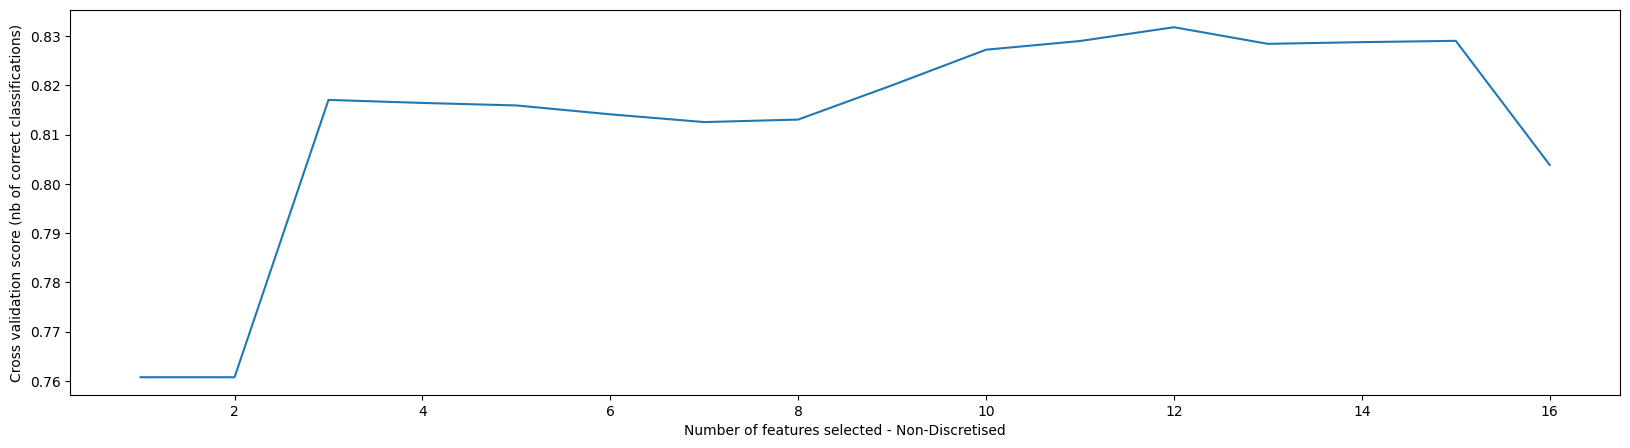

In [60]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(20,5))
plt.xlabel("Number of features selected - Non-Discretised")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector1.cv_results_['mean_test_score']) + 1), selector1.cv_results_['mean_test_score'])

# Seleccionando el Dataset
Tenemos dos opciones de dataset que hemos ido creado, bin y con, recordemos que hablamos de hacer buckets para mejorar el desempeño de los algoritmos de ML

In [61]:
# OPTIONS:
# - dataset_bin_enc
# - dataset_con_enc

# Change the dataset to test how would the algorithms perform under a differently encoded dataset.

selected_dataset = dataset_con_enc
selected_dataset.head(2)

predclass  age  workclass  occupation  native-country  education  \
0          0   22          1           0               7          1   
1          0   33          4           3               7          1   

   marital-status  fnlwgt  education-num  hours-per-week  capital-gain  \
0               1    3461             12              39            27   
1               0    3788             12              12             0   

   capital-loss  sex  race  relationship  age-hours  sex-marital  
0             0    1     4             1        695            6  
1             0    1     4             0        334            5

In [62]:
# Divir el dataset en train y test
train = selected_dataset.loc[0:32560,:]
test = selected_dataset.loc[32560:,:]

In [63]:
# Eliminaamos datos nulos dado que son una pequeña cantidad de todo nuestro dataset
train = train.dropna(axis=0)
test = test.dropna(axis=0)

In [64]:
X_train_w_label = train
X_train = train.drop(['predclass'], axis=1)
y_train = train['predclass'].astype('int64')
X_test  = test.drop(['predclass'], axis=1)
y_test  = test['predclass'].astype('int64')

# Acomodamos y damos nombres apropiados a las variables de nuestro dataset, recordemos que X se conoce como la matrix de samples y features mientras que Y se conoce como el target

# Modelos de Clasificación con ML
El día de hoy vamos a experimentar vario modelos de ML
- KNN
- Logistic Regression
- Random Forest
- Naive Bayes
- SGD (Stochastic Gradient Decent
- Linear SVC
- Decision Tress
- Gradient Boosted Trees
Primero que nada vamos a establecer algunos métodos que podemos reutilizar entre modelos

In [66]:
# calculate the fpr and tpr for all thresholds of the classification
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [67]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, X_test, cv):
    # One Pass
    model = algo.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    if (isinstance(algo, (LogisticRegression,
                          KNeighborsClassifier,
                          GaussianNB,
                          DecisionTreeClassifier,
                          RandomForestClassifier,
                          GradientBoostingClassifier))):
        probs = model.predict_proba(X_test)[:,1]
    else:
        probs = "Not Available"
    acc = round(model.score(X_test, y_test) * 100, 2)
    # CV
    train_pred = model_selection.cross_val_predict(algo,
                                                  X_train,
                                                  y_train,
                                                  cv=cv,
                                                  n_jobs = -1)
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    return train_pred, test_pred, acc, acc_cv, probs

In [68]:
# Logistic Regression - Random Search for Hyperparameters

# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# Specify parameters and distributions to sample from
param_dist = {'penalty': ['l2', 'l1'],
                         'class_weight': [None, 'balanced'],
                         'C': np.logspace(-20, 20, 10000),
                         'intercept_scaling': np.logspace(-20, 20, 10000)}

# Run Randomized Search
n_iter_search = 10
lrc = LogisticRegression()
random_search = RandomizedSearchCV(lrc,
                                   n_jobs=-1,
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 14.20 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.803 (std: 0.005)
Parameters: {'penalty': 'l2', 'intercept_scaling': 0.08747706220142601, 'class_weight': None, 'C': 301403238781.55}

Model with rank: 2
Mean validation score: 0.794 (std: 0.002)
Parameters: {'penalty': 'l2', 'intercept_scaling': 168819551547313.56, 'class_weight': None, 'C': 9.580719820772551e-07}

Model with rank: 3
Mean validation score: 0.763 (std: 0.017)
Parameters: {'penalty': 'l2', 'intercept_scaling': 0.03418640122240816, 'class_weight': 'balanced', 'C': 140415400001092.61}

Model with rank: 4
Mean validation score: 0.758 (std: 0.001)
Parameters: {'penalty': 'l2', 'intercept_scaling': 2.9427059995436513e-13, 'class_weight': None, 'C': 1.0695545024627121e-08}

Model with rank: 5
Mean validation score: 0.757 (std: 0.012)
Parameters: {'penalty': 'l2', 'intercept_scaling': 9.392847682415934e-13, 'class_weight': 'balanced', 'C': 365473830.9850332}



In [69]:
# Logistic Regression
start_time = time.time()
train_pred_log, test_pred_log, acc_log, acc_cv_log, probs_log = fit_ml_algo(LogisticRegression(n_jobs = -1),
                                                                 X_train,
                                                                 y_train,
                                                                 X_test,
                                                                 10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 80.6
Accuracy CV 10-Fold: 80.73
Running Time: 0:00:03.510736


In [70]:
print(metrics.classification_report(y_train, train_pred_log))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88     24720
           1       0.69      0.37      0.48      7841

    accuracy                           0.81     32561
   macro avg       0.76      0.66      0.68     32561
weighted avg       0.79      0.81      0.78     32561



In [71]:
print(metrics.classification_report(y_test, test_pred_log))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88     12435
           1       0.68      0.34      0.45      3847

    accuracy                           0.81     16282
   macro avg       0.75      0.64      0.67     16282
weighted avg       0.79      0.81      0.78     16282



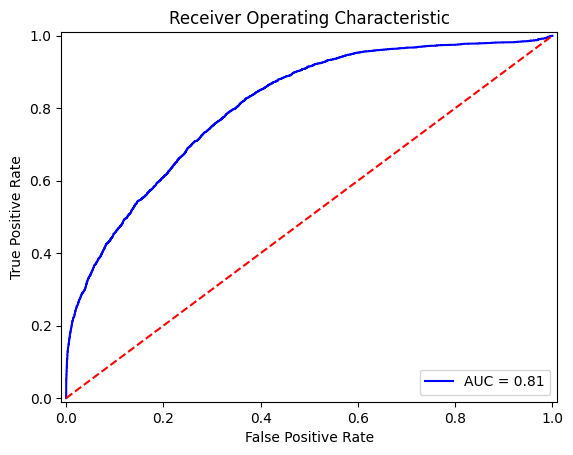

In [72]:
plot_roc_curve(y_test, probs_log)

In [73]:
# k-Nearest Neighbors
start_time = time.time()
train_pred_knn, test_pred_knn, acc_knn, acc_cv_knn, probs_knn = fit_ml_algo(KNeighborsClassifier(n_neighbors = 3,
                                                                                                 n_jobs = -1),
                                                                                                 X_train,
                                                                                                 y_train,
                                                                                                 X_test,
                                                                                                 10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 75.25
Accuracy CV 10-Fold: 74.98
Running Time: 0:01:49.559608


In [74]:
print(metrics.classification_report(y_train, train_pred_knn))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84     24720
           1       0.47      0.33      0.39      7841

    accuracy                           0.75     32561
   macro avg       0.64      0.61      0.62     32561
weighted avg       0.73      0.75      0.73     32561



In [75]:
print(metrics.classification_report(y_test, test_pred_knn))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85     12435
           1       0.47      0.32      0.38      3847

    accuracy                           0.75     16282
   macro avg       0.64      0.60      0.61     16282
weighted avg       0.73      0.75      0.74     16282



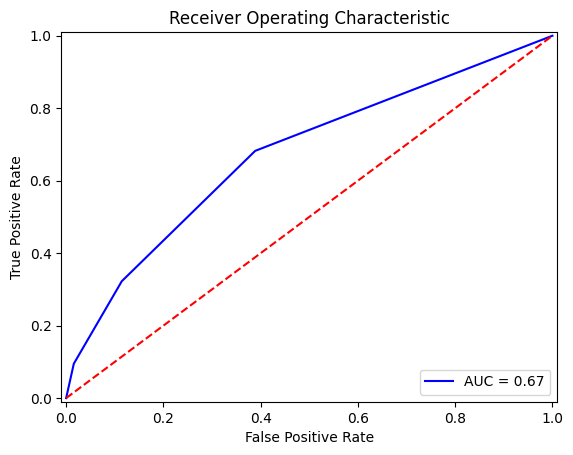

In [76]:
plot_roc_curve(y_test, probs_knn)

In [79]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, test_pred_gaussian, acc_gaussian, acc_cv_gaussian, probs_gau = fit_ml_algo(GaussianNB(),
                                                                                     X_train,
                                                                                     y_train,
                                                                                     X_test,
                                                                                     10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 81.97
Accuracy CV 10-Fold: 82.13
Running Time: 0:00:00.370987


In [80]:
print(metrics.classification_report(y_train, train_pred_gaussian))

              precision    recall  f1-score   support

           0       0.87      0.91      0.88     24720
           1       0.65      0.56      0.60      7841

    accuracy                           0.82     32561
   macro avg       0.76      0.73      0.74     32561
weighted avg       0.81      0.82      0.82     32561



In [81]:
print(metrics.classification_report(y_test, test_pred_gaussian))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88     12435
           1       0.64      0.56      0.59      3847

    accuracy                           0.82     16282
   macro avg       0.75      0.73      0.74     16282
weighted avg       0.81      0.82      0.82     16282



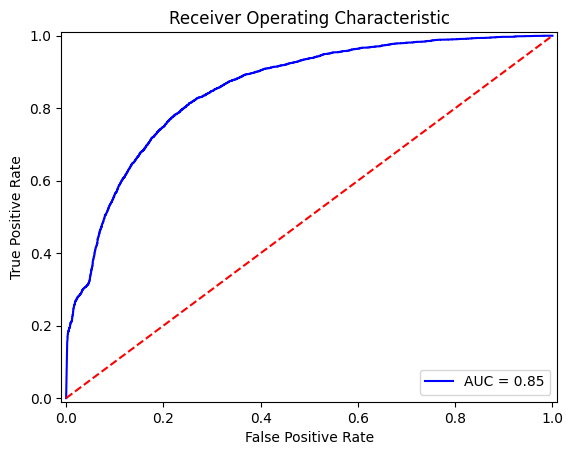

In [82]:
plot_roc_curve(y_test, probs_gau)

In [83]:
# Linear SVC
start_time = time.time()
train_pred_svc, test_pred_svc, acc_linear_svc, acc_cv_linear_svc, _ = fit_ml_algo(LinearSVC(),
                                                                                           X_train,
                                                                                           y_train,
                                                                                           X_test,
                                                                                           10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 79.08
Accuracy CV 10-Fold: 71.89
Running Time: 0:01:46.318135


In [84]:
print(metrics.classification_report(y_train, train_pred_svc))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82     24720
           1       0.41      0.40      0.41      7841

    accuracy                           0.72     32561
   macro avg       0.61      0.61      0.61     32561
weighted avg       0.72      0.72      0.72     32561



In [85]:
print(metrics.classification_report(y_test, test_pred_svc))

              precision    recall  f1-score   support

           0       0.81      0.95      0.87     12435
           1       0.63      0.28      0.38      3847

    accuracy                           0.79     16282
   macro avg       0.72      0.61      0.63     16282
weighted avg       0.77      0.79      0.76     16282



In [86]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, test_pred_sgd, acc_sgd, acc_cv_sgd, _ = fit_ml_algo(SGDClassifier(n_jobs = -1),
                                                                 X_train,
                                                                 y_train,
                                                                 X_test,
                                                                 10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 77.14
Accuracy CV 10-Fold: 76.0
Running Time: 0:00:14.424782


In [87]:

print(metrics.classification_report(y_train, train_pred_sgd))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85     24720
           1       0.50      0.35      0.41      7841

    accuracy                           0.76     32561
   macro avg       0.66      0.62      0.63     32561
weighted avg       0.74      0.76      0.74     32561



In [88]:
print(metrics.classification_report(y_test, test_pred_sgd))

              precision    recall  f1-score   support

           0       0.78      0.98      0.87     12435
           1       0.60      0.09      0.16      3847

    accuracy                           0.77     16282
   macro avg       0.69      0.54      0.52     16282
weighted avg       0.74      0.77      0.70     16282



In [89]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, test_pred_dt, acc_dt, acc_cv_dt, probs_dt = fit_ml_algo(DecisionTreeClassifier(),
                                                             X_train,
                                                             y_train,
                                                             X_test,
                                                             10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 81.46
Accuracy CV 10-Fold: 80.61
Running Time: 0:00:02.122403


In [90]:
print(metrics.classification_report(y_train, train_pred_dt))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87     24720
           1       0.60      0.61      0.60      7841

    accuracy                           0.81     32561
   macro avg       0.74      0.74      0.74     32561
weighted avg       0.81      0.81      0.81     32561



In [91]:
print(metrics.classification_report(y_test, test_pred_dt))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88     12435
           1       0.60      0.62      0.61      3847

    accuracy                           0.81     16282
   macro avg       0.74      0.75      0.75     16282
weighted avg       0.82      0.81      0.82     16282



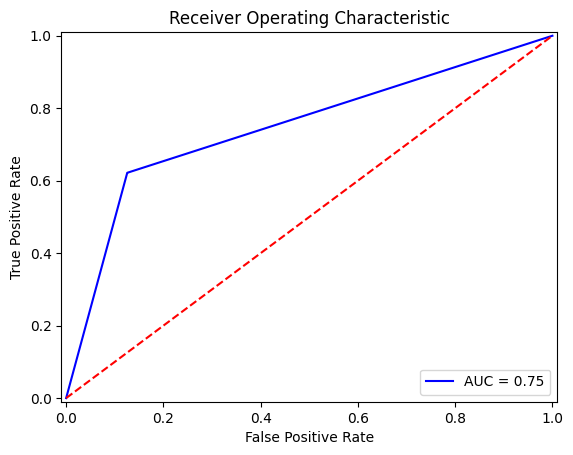

In [92]:
plot_roc_curve(y_test, probs_dt)

In [93]:
# Random Forest Classifier - Random Search for Hyperparameters

# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# Specify parameters and distributions to sample from
param_dist = {"max_depth": [10, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 20),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# Run Randomized Search
n_iter_search = 10
rfc = RandomForestClassifier(n_estimators=10)
random_search = RandomizedSearchCV(rfc,
                                   n_jobs = -1,
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 21.97 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.862 (std: 0.002)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 18}

Model with rank: 2
Mean validation score: 0.861 (std: 0.004)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 8, 'min_samples_leaf': 6, 'min_samples_split': 12}

Model with rank: 3
Mean validation score: 0.859 (std: 0.004)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 10, 'min_samples_split': 14}

Model with rank: 4
Mean validation score: 0.858 (std: 0.006)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 9, 'min_samples_leaf': 8, 'min_samples_split': 3}

Model with rank: 5
Mean validation score: 0.858 (std: 0.005)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 

In [94]:
# Random Forest Classifier
start_time = time.time()
rfc = RandomForestClassifier(n_estimators=10,
                             min_samples_leaf=2,
                             min_samples_split=17,
                             criterion='gini',
                             max_features=8)
train_pred_rf, test_pred_rf, acc_rf, acc_cv_rf, probs_rf = fit_ml_algo(rfc,
                                                             X_train,
                                                             y_train,
                                                             X_test,
                                                             10)
rf_time = (time.time() - start_time)
print("Accuracy: %s" % acc_rf)
print("Accuracy CV 10-Fold: %s" % acc_cv_rf)
print("Running Time: %s" % datetime.timedelta(seconds=rf_time))

Accuracy: 85.62
Accuracy CV 10-Fold: 85.62
Running Time: 0:00:09.261192


In [95]:
print(metrics.classification_report(y_train, train_pred_rf))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91     24720
           1       0.74      0.61      0.67      7841

    accuracy                           0.86     32561
   macro avg       0.81      0.77      0.79     32561
weighted avg       0.85      0.86      0.85     32561



In [96]:
print(metrics.classification_report(y_test, test_pred_rf))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     12435
           1       0.74      0.61      0.67      3847

    accuracy                           0.86     16282
   macro avg       0.81      0.77      0.79     16282
weighted avg       0.85      0.86      0.85     16282



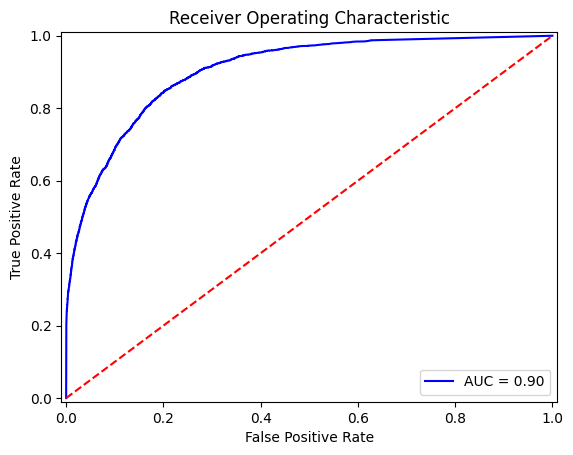

In [97]:
plot_roc_curve(y_test, probs_rf)

In [98]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, test_pred_gbt, acc_gbt, acc_cv_gbt, probs_gbt = fit_ml_algo(GradientBoostingClassifier(),
                                                                 X_train,
                                                                 y_train,
                                                                 X_test,
                                                                 10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 86.79
Accuracy CV 10-Fold: 86.55
Running Time: 0:00:47.271245


In [99]:
print(metrics.classification_report(y_train, train_pred_gbt))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     24720
           1       0.79      0.61      0.68      7841

    accuracy                           0.87     32561
   macro avg       0.83      0.78      0.80     32561
weighted avg       0.86      0.87      0.86     32561



In [100]:
print(metrics.classification_report(y_test, test_pred_gbt))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     12435
           1       0.79      0.60      0.68      3847

    accuracy                           0.87     16282
   macro avg       0.84      0.78      0.80     16282
weighted avg       0.86      0.87      0.86     16282



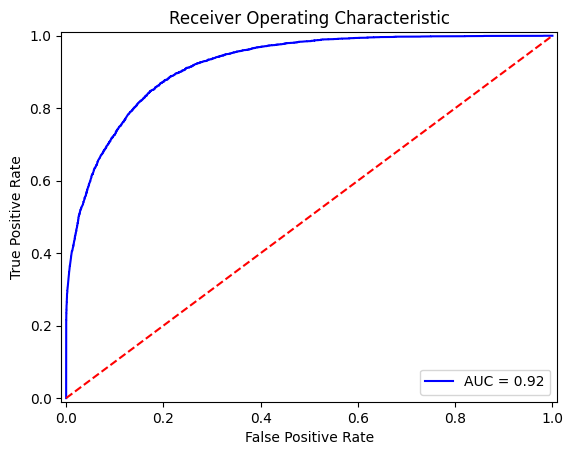

In [101]:
plot_roc_curve(y_test, probs_gbt)

# Resultados

In [102]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression',
              'Random Forest', 'Naive Bayes',
              'Stochastic Gradient Decent', 'Linear SVC',
              'Decision Tree', 'Gradient Boosting Trees'],
    'Score': [
        acc_knn,
        acc_log,
        acc_rf,
        acc_gaussian,
        acc_sgd,
        acc_linear_svc,
        acc_dt,
        acc_gbt
    ]})
models.sort_values(by='Score', ascending=False)

Model  Score
7     Gradient Boosting Trees  86.79
2               Random Forest  85.62
3                 Naive Bayes  81.97
6               Decision Tree  81.46
1         Logistic Regression  80.60
5                  Linear SVC  79.08
4  Stochastic Gradient Decent  77.14
0                         KNN  75.25

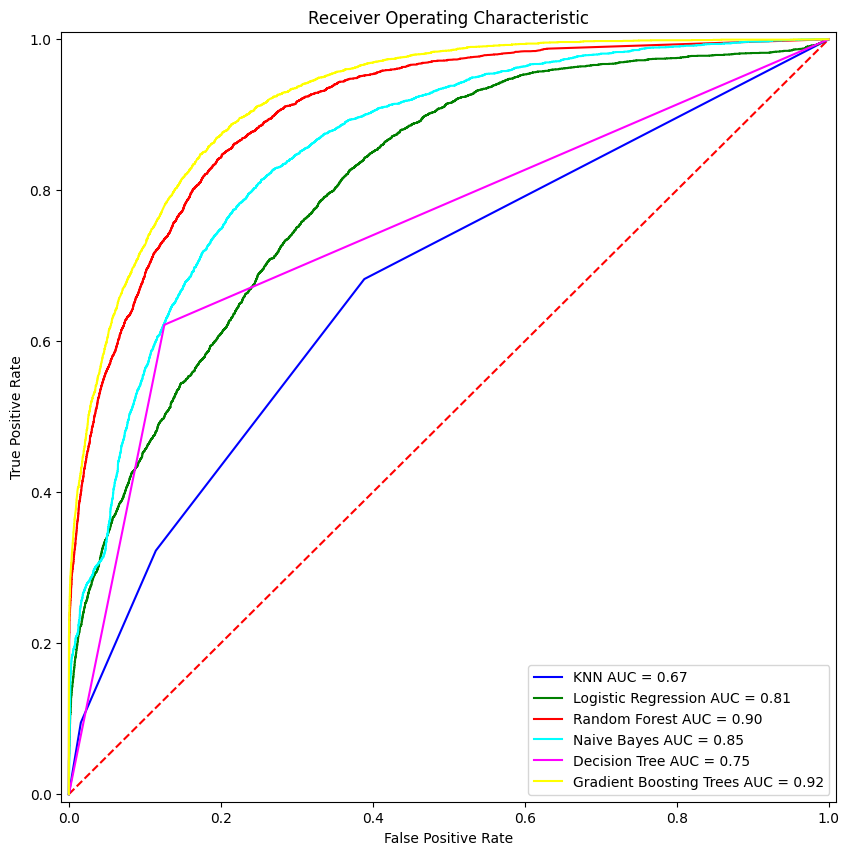

In [103]:
fig = plt.figure(figsize=(10,10))

models = [
    'KNN',
    'Logistic Regression',
    'Random Forest',
    'Naive Bayes',
    'Decision Tree',
    'Gradient Boosting Trees'
]
probs = [
    probs_knn,
    probs_log,
    probs_rf,
    probs_gau,
    probs_dt,
    probs_gbt
]
colors = [
    'blue',
    'green',
    'red',
    'cyan',
    'magenta',
    'yellow',
]

plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

def plot_roc_curves(y_test, prob, model):
    fpr, tpr, threshold = metrics.roc_curve(y_test, prob)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = model + ' AUC = %0.2f' % roc_auc, color=colors[i])
    plt.legend(loc = 'lower right')

for i, model in list(enumerate(models)):
    plot_roc_curves(y_test, probs[i], models[i])

plt.show()